## Import Library

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from collections import Counter
import math
import scipy.stats as ss

from IPython.display import Image
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-darkgrid')

In [31]:
## Theils u
def conditional_entropy(x,y):
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy

def theil_u(x,y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

## Import Data

In [32]:
df = pd.read_csv('hotel_bookings.csv')

In [33]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


## Exploratory Data Analysis

### *1. Main Parameter*

Parameter utama pada analisis kali ini adalah:
- Target karena aspek utama dalam mengetahui perilaku pemesan yang melakukan pembatalan
- Hotel karena data merupakan gabungan dari 2 jenis hotel yaitu City Hotel dan Resort Hotel
- ADR karena mengetajui nilai penjualan serta keuntungan

#### - Target

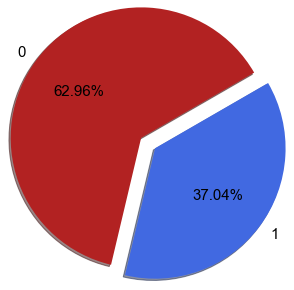

In [34]:
persentase = [df[df['is_canceled'] == 0]['is_canceled'].count(), df[df['is_canceled'] == 1]['is_canceled'].count()]
nama = [0, 1]
cmap = plt.get_cmap('Set3')
# warna = [cmap(i) for i in np.linspace(0, 1, 5)]

plt.pie(
    persentase,
    labels=nama,
    colors=['firebrick', 'royalblue'],
    startangle=30,
    shadow=True,
    radius=1.5,
    textprops={
        'size' : 15,
        'color' : 'k'
    },
    autopct='%1.2f%%',
    explode=(.1, .1)
    )
plt.show()

Terlihat bahwa pada kolom target atau pemesanan dapat dikatehui bahwa tidak berimbang namun masih dalam tahap masih bisa diterima

In [35]:
df['is_canceled'].value_counts()

0    75166
1    44224
Name: is_canceled, dtype: int64

Sejumlah 44224 transaksi yang dibatalkan dan 7516 transaksi yang tidak dibatalkan

In [36]:
df.groupby(['is_canceled'])['adr'].sum()

is_canceled
0    7515674.93
1    4641942.67
Name: adr, dtype: float64

Terdapat kerugian atau jumlah pembatalan yang mengakibatkan kehilangan pendapatan sebesar 4641942.67

In [37]:
df.groupby(['is_canceled','hotel'])['adr'].sum()

is_canceled  hotel       
0            City Hotel      4888423.70
             Resort Hotel    2627251.23
1            City Hotel      3465379.54
             Resort Hotel    1176563.13
Name: adr, dtype: float64

In [38]:
df.groupby(['is_canceled','hotel'])['adr'].mean()

is_canceled  hotel       
0            City Hotel      105.745948
             Resort Hotel     90.788971
1            City Hotel      104.687920
             Resort Hotel    105.787010
Name: adr, dtype: float64

Hipotesis sementara :
- Data menampilkan jumlah pembatalan sebesar 37.04% atau 44224 transaski yang dibatalkan
- Total ADR yang melakukan pembatalan atau kerugian sebesar 4641942.67
- Secara jumlah ADR pembatalan secara jenis city hotel lebih banyak dibanding resort hotel, namun untuk per transaksi tidak terlalu jauh

#### - Hotel

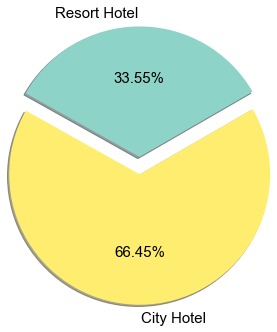

In [39]:
kolom = df['hotel']
persen = []
nama = []
for i in kolom.unique():
    nama.append(i)
    persen.append(len(df[kolom == i]))
    
cmap = plt.get_cmap('Set3')
warna = [cmap(i) for i in np.linspace(0, 1, len(nama))]

plt.pie(
    persen,
    labels=nama,
    colors=warna,
    startangle=30,
    shadow=True,
    radius=1.5,
    textprops={
        'size' : 15,
        'color' : 'k'
    },
    autopct='%1.2f%%',
    explode=(.1, .1)
    )
plt.show()

- Dapat terlihat bahwa pemesanan historis pada hotel diketahui paling banyak di city hotel atau di Lisbon dibandingkan dengan yang memesan di Algrave
- Dipisahkan karena pada jurnal terlihat bahwa jenis 2 hotel tersebut merupakan 2 data yang berbeda

####  - ADR

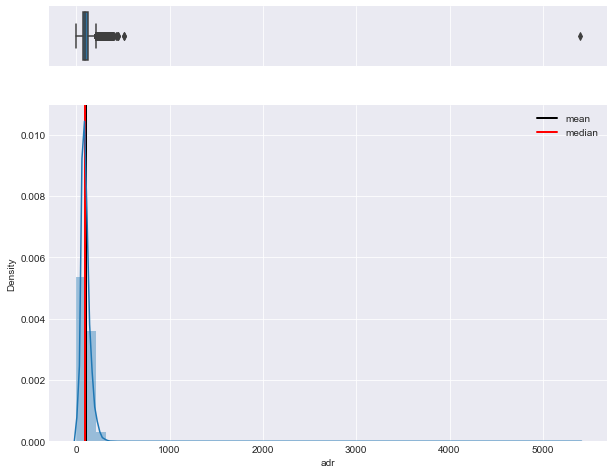

In [40]:
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(figsize=(10,8), nrows=2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
ax_hist.axvline(x=df["adr"].mean(), linewidth=2, color = 'k', label='mean') 
ax_hist.axvline(x=df["adr"].median(), linewidth=2, color = 'r', label='median')
sns.boxplot(df["adr"], ax=ax_box)
sns.distplot(df["adr"], ax=ax_hist)

ax_hist.legend()
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
plt.show()

In [41]:
df.sort_values(by=['adr'],ascending=False)['adr'].head(5)

48515     5400.0
111403     510.0
15083      508.0
103912     451.5
13142      450.0
Name: adr, dtype: float64

In [42]:
df[df['adr'] == 5400]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
48515,City Hotel,1,35,2016,March,13,25,0,1,2,0.0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,1,Non Refund,12.0,NaN,0,Transient,5400.0,0,0,Canceled,2016-02-19


Terdapat outlier pada adr. Namun terdapat outlier yang sangat berbeda jauh yaitu sebesar 5400, terlihat dari besar adr pertama dengan kedua yang berbeda jauh dan jumlah adults, stays dan pada bulan yang bisa dikatakan dengan adr yang biasa. Sehingga 5400 dapat dihilangkan

In [43]:
df = df[df['adr'] != 5400]

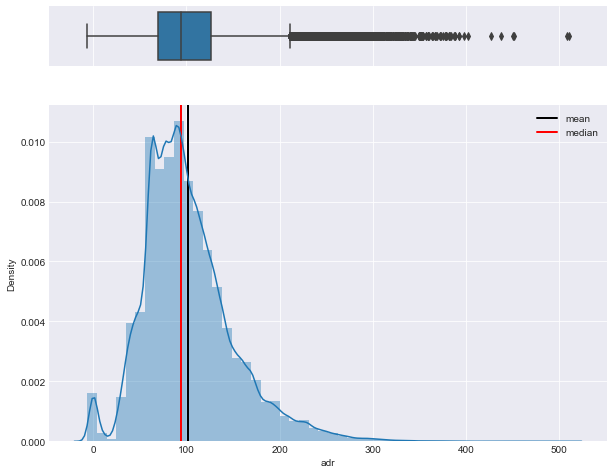

In [44]:
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(figsize=(10,8), nrows=2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
ax_hist.axvline(x=df["adr"].mean(), linewidth=2, color = 'k', label='mean') 
ax_hist.axvline(x=df["adr"].median(), linewidth=2, color = 'r', label='median')
sns.boxplot(df["adr"], ax=ax_box)
sns.distplot(df["adr"], ax=ax_hist)

ax_hist.legend()
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
plt.show()

In [45]:
col = df['adr']
print(f'Stays Mean   : {col.mean().round(2)}')
print(f'Stays Median : {col.median()}')

Stays Mean   : 101.79
Stays Median : 94.56


In [46]:
print(f'Kolom ADR memiliki Skew {col.skew()} dan Kurtosis {col.kurt()}')

Kolom ADR memiliki Skew 1.0177314465480856 dan Kurtosis 2.1317452262138805


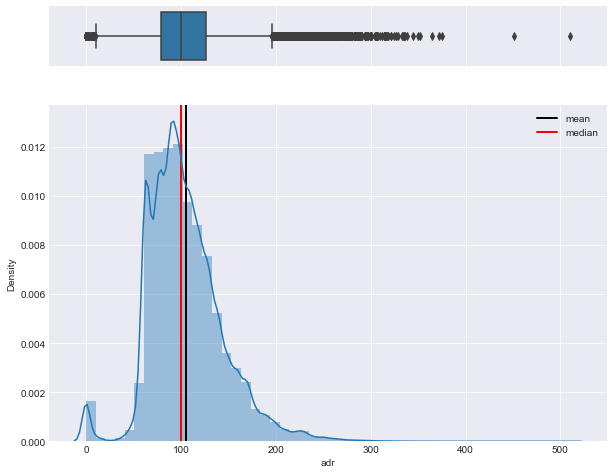

In [47]:
col = df[df['hotel'] == 'City Hotel']['adr']
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(figsize=(10,8), nrows=2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
ax_hist.axvline(x=col.mean(), linewidth=2, color = 'k', label='mean') 
ax_hist.axvline(x=col.median(), linewidth=2, color = 'r', label='median')
sns.boxplot(col, ax=ax_box)
sns.distplot(col, ax=ax_hist)

ax_hist.legend()
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
plt.show()

In [48]:
print(f'Stays City Hotel Mean   : {col.mean().round(2)}')
print(f'Stays City Hotel Median : {col.median()}')

Stays City Hotel Mean   : 105.24
Stays City Hotel Median : 99.9


In [49]:
print(f'Kolom ADR memiliki Skew {col.skew()} dan Kurtosis {col.kurt()}')

Kolom ADR memiliki Skew 0.8090438748126672 dan Kurtosis 2.3960492776588067


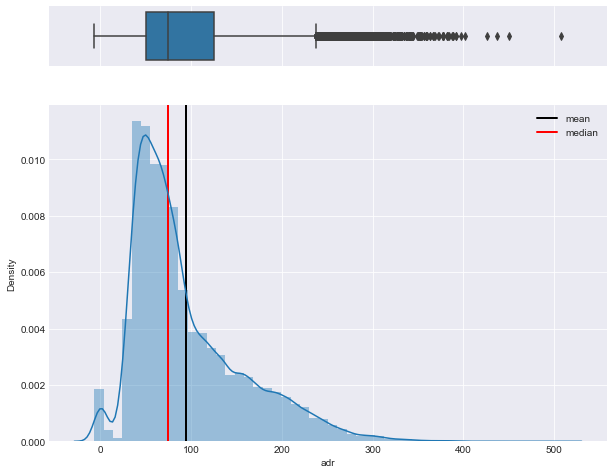

In [50]:
col = df[df['hotel'] == 'Resort Hotel']['adr']
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(figsize=(10,8), nrows=2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
ax_hist.axvline(x=col.mean(), linewidth=2, color = 'k', label='mean') 
ax_hist.axvline(x=col.median(), linewidth=2, color = 'r', label='median')
sns.boxplot(col, ax=ax_box)
sns.distplot(col, ax=ax_hist)

ax_hist.legend()
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
plt.show()

In [51]:
print(f'Stays Resort Hotel Mean   : {col.mean().round(2)}')
print(f'Stays Resort Hotel Median : {col.median()}')

Stays Resort Hotel Mean   : 94.95
Stays Resort Hotel Median : 75.0


In [52]:
print(f'Kolom ADR memiliki Skew {col.skew()} dan Kurtosis {col.kurt()}')

Kolom ADR memiliki Skew 1.2373891514324238 dan Kurtosis 1.3400804634200236


- Nilai skew ADR resort hotel lebih besar dibandingkan city hotel, menandakan ADR pada resort hotel terdistribusi lebih luas (range antara min dengan max lebih lebar atau besar) dibandingkan dengan city hotel
- Nilai kurtosis ADR city hotel lebih besar dibandingkan resort hotel, menandakan ADR pada city hotel memiliki nilai adr yang sama dibandingkan dengan resort hotel
- Semakin dekat nilai skew dan kurtosis dengan nilai ideal maka distribusi ADR semakin baik, atau ADR City Hotel memiliki distribusi yang baik dibandingkan dengan Resort hotel
- Secara data keseluruhan ADR terlihat bahwa distribusinya baik dan nilai ADR yang sama banyak sekali atau variasi ADR tidak begitu banyak atau luas namun banyak ADR yang sama pada dataset tersebut

### 2. Trends

In [53]:
df['arrival_date'] = df['arrival_date_month'].astype(str) + '/' + df['arrival_date_day_of_month'].astype(str) +'/' + df['arrival_date_year'].astype(str)
df['arrival_date'] = pd.to_datetime(df['arrival_date'])
df['arrival_month'] = df['arrival_date'].dt.to_period('M').astype(str)

#### - Transaction

In [54]:
data_trans = []

for i in df['arrival_month'].unique():
    data_trans.append([
        i,
        len(df[df['arrival_month'] == i]),
        len(df[(df['arrival_month'] == i) & (df['hotel'] == 'Resort Hotel')])
    ])
data_trans = pd.DataFrame(data_trans, columns = ['month_year', 'sum_trans', 'resort_trans'])

data_trans['city_trans'] = data_trans['sum_trans'] - data_trans['resort_trans']

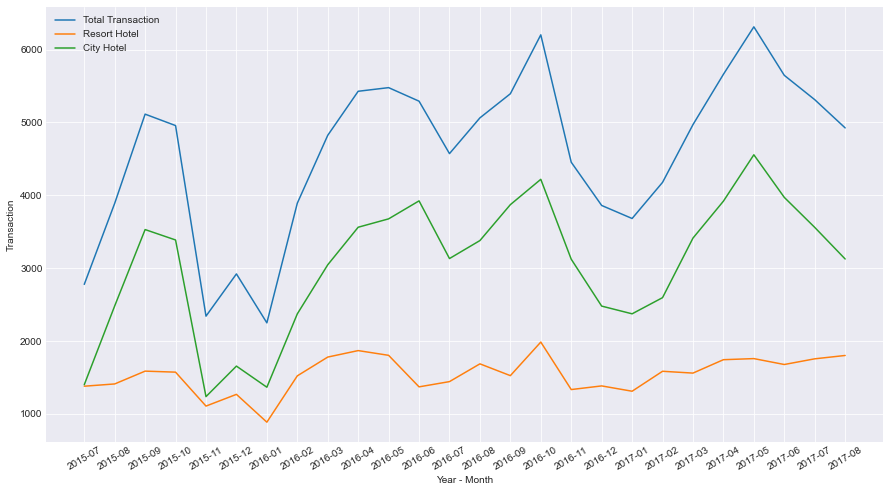

In [55]:
plt.figure(figsize=(15, 8))
sns.lineplot(x='month_year',y='sum_trans', data=data_trans, ci=False, markers=True)
sns.lineplot(x='month_year',y='resort_trans', data=data_trans, ci=False)
sns.lineplot(x='month_year',y='city_trans', data=data_trans, ci=False)
plt.xticks(fontsize=10, rotation=30)
plt.xlabel('Year - Month')
plt.ylabel('Transaction')
plt.legend(['Total Transaction', 'Resort Hotel', 'City Hotel'], loc=0)
plt.show()

In [56]:
data_trans.set_index('month_year').T

month_year,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08
sum_trans,2776,3889,5114,4957,2340,2920,2248,3891,4823,5428,5478,5292,4572,5063,5394,6203,4454,3860,3681,4177,4970,5661,6313,5647,5313,4925
resort_trans,1378,1409,1585,1571,1105,1266,884,1520,1778,1867,1802,1369,1441,1685,1523,1984,1332,1382,1309,1583,1558,1742,1757,1676,1754,1800
city_trans,1398,2480,3529,3386,1235,1654,1364,2371,3045,3561,3676,3923,3131,3378,3871,4219,3122,2478,2372,2594,3412,3919,4556,3971,3559,3125


In [57]:
(pd.crosstab(index=df['arrival_month'], columns=df['hotel'], normalize='index')*100).round(2).T

arrival_month,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08
hotel,,,,,,,,,,,,,,,,,,,,,,,,,,
City Hotel,50.36,63.77,69.01,68.31,52.78,56.64,60.68,60.94,63.13,65.6,67.1,74.13,68.48,66.72,71.76,68.02,70.09,64.2,64.44,62.1,68.65,69.23,72.17,70.32,66.99,63.45
Resort Hotel,49.64,36.23,30.99,31.69,47.22,43.36,39.32,39.06,36.87,34.4,32.9,25.87,31.52,33.28,28.24,31.98,29.91,35.8,35.56,37.9,31.35,30.77,27.83,29.68,33.01,36.55


Secara jumlah transaksi untuk seluruh hotel, dapat diketahui bahwa :
- Pemesanan bulan November 2015 sampai Januari 2016 sangat sedikit dibandingkan dengan yang lain
- Pemesanan bulan September 2016 dan Mei 2017 sangat tinggi dibandingkan dengan bulan yang lain
- Secara total sering terjadi penurunan setiap pada bulan Januari

#### - Target

In [58]:
data_target = []

for i in df['arrival_month'].unique():
    data_target.append([
        i,
        len(df[df['arrival_month'] == i]),
        len(df[(df['arrival_month'] == i) & (df['is_canceled'] == 0)])
    ])
data_target = pd.DataFrame(data_target, columns = ['month_year', 'sum_target', '0'])

data_target['1'] = data_target['sum_target'] - data_target['0']

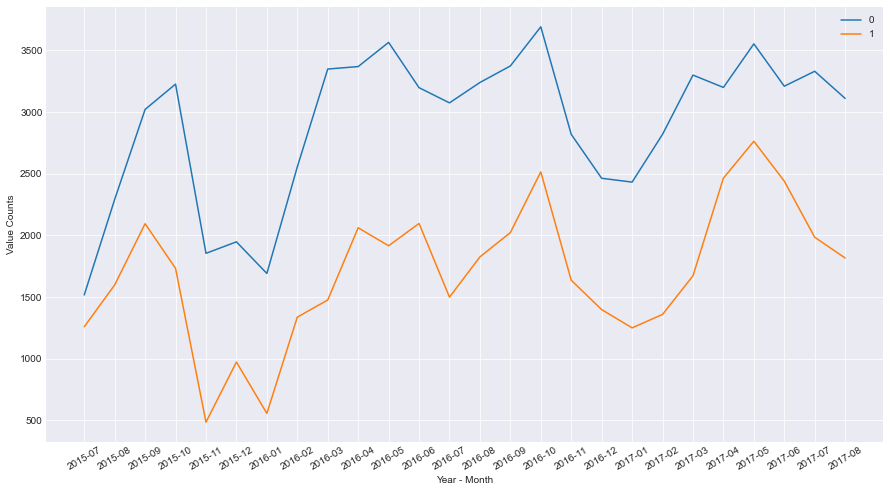

In [59]:
plt.figure(figsize=(15, 8))
sns.lineplot(x='month_year',y='0', data=data_target, ci=False, markers=True)
sns.lineplot(x='month_year',y='1', data=data_target, ci=False)
plt.xticks(fontsize=10, rotation=30)
plt.ylabel('Value Counts')
plt.xlabel('Year - Month')
plt.legend(['0', '1'], loc=0)
plt.show()

In [60]:
pd.crosstab(index=df['arrival_month'], columns=df['is_canceled'], values=df['is_canceled'], aggfunc='count').T

arrival_month,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08
is_canceled,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1517,2291,3020,3225,1854,1947,1691,2554,3347,3367,3563,3196,3073,3238,3372,3689,2818,2462,2431,2818,3298,3198,3551,3208,3329,3109
1,1259,1598,2094,1732,486,973,557,1337,1476,2061,1915,2096,1499,1825,2022,2514,1636,1398,1250,1359,1672,2463,2762,2439,1984,1816


In [61]:
(pd.crosstab(index=df['arrival_month'], columns=df['is_canceled'], normalize='index')*100).round(2).T

arrival_month,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08
is_canceled,,,,,,,,,,,,,,,,,,,,,,,,,,
0,54.65,58.91,59.05,65.06,79.23,66.68,75.22,65.64,69.4,62.03,65.04,60.39,67.21,63.95,62.51,59.47,63.27,63.78,66.04,67.46,66.36,56.49,56.25,56.81,62.66,63.13
1,45.35,41.09,40.95,34.94,20.77,33.32,24.78,34.36,30.6,37.97,34.96,39.61,32.79,36.05,37.49,40.53,36.73,36.22,33.96,32.54,33.64,43.51,43.75,43.19,37.34,36.87


In [62]:
pd.crosstab(index=df['arrival_month'], columns=df['is_canceled']).sort_values(by=[1],ascending=False).head(5)

is_canceled,0,1
arrival_month,,
2017-05,3551,2762
2016-10,3689,2514
2017-04,3198,2463
2017-06,3208,2439
2016-06,3196,2096


In [63]:
(pd.crosstab(index=df['arrival_month'], columns=df['is_canceled'], normalize='index')
    .mul(100)
    .round(2)
    .sort_values(by=[1],ascending=False)
    .head(5))

is_canceled,0,1
arrival_month,,
2015-07,54.65,45.35
2017-05,56.25,43.75
2017-04,56.49,43.51
2017-06,56.81,43.19
2015-08,58.91,41.09


- Untuk proporsi atau perbandingan yang melakukan pembatalan dengan tidak untuk setiap bulan dan tahunnya masih bisa dikatakan bisa diterima atau salah satu target tidak lebih besar 80%
- 2017-05 Merupakan banyak orang yang melakukan pembatalan
- 2015-07 Secara perbandingan banyak melakukan pembatalan dibanding waktu lain

#### - ADR

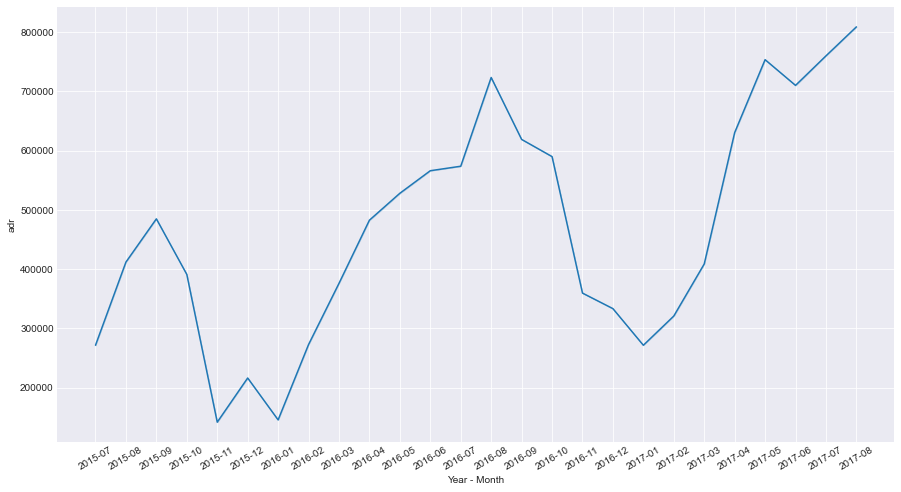

In [64]:
plt.figure(figsize=(15, 8))
sns.lineplot(x='arrival_month',y='adr', data=df, estimator='sum', ci=False)
plt.xticks(fontsize=10, rotation=30)
plt.xlabel('Year - Month')
plt.show()

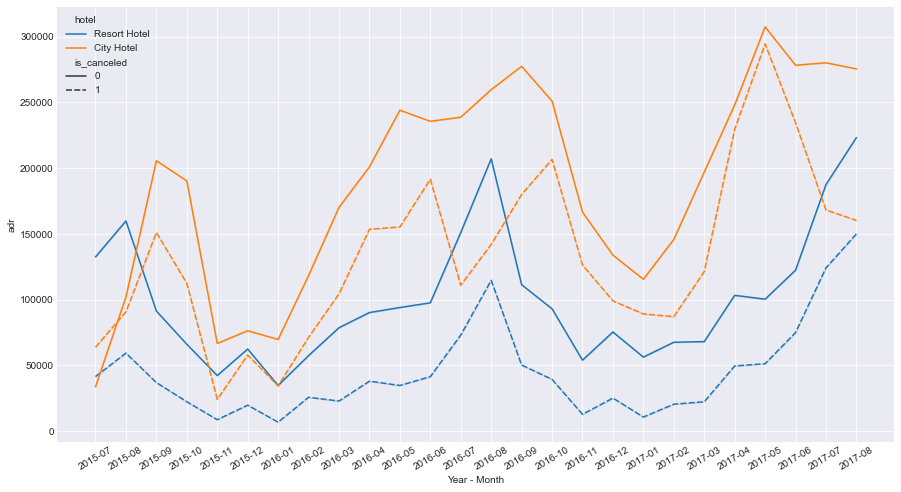

In [65]:
plt.figure(figsize=(15, 8))
sns.lineplot(x='arrival_month',y='adr', data=df, hue='hotel', style='is_canceled', estimator='sum', ci=False)
plt.xticks(fontsize=10, rotation=30)
plt.xlabel('Year - Month')
plt.show()

In [66]:
pd.crosstab(index=df['arrival_month'], columns=[df['hotel'], df['is_canceled']], values=df['adr'], aggfunc='sum', margins=True).T

arrival_month               2015-07    2015-08    2015-09    2015-10  \
hotel        is_canceled                                               
City Hotel   0             33778.49  102011.64  205622.78  190286.20   
             1             63828.71   90756.77  151033.74  112398.88   
Resort Hotel 0            132483.67  159827.34   91326.80   66056.30   
             1             41497.19   59338.36   36919.32   22343.25   
All                       271588.06  411934.11  484902.64  391084.63   

arrival_month               2015-11    2015-12    2016-01    2016-02  \
hotel        is_canceled                                               
City Hotel   0             66673.87   76319.22   69726.36  118278.75   
             1             24150.33   57833.68   34384.19   71346.20   
Resort Hotel 0             42248.35   62411.74   34697.93   57404.99   
             1              8685.24   19746.75    6789.21   25737.99   
All                       141757.79  216311.39  145597.69  272767.93   

arrival_month               2016-03    2016-04    2016-05    2016-06  \
hotel        is_canceled                                               
City Hotel   0            170168.84  200986.08  244060.12  235618.76   
             1            104360.51  153510.42  155300.46  191547.18   
Resort Hotel 0             78633.03   90187.78   94000.72   97557.60   
             1             22868.05   37967.62   34713.99   41400.41   
All                       376030.43  482651.90  528075.29  566123.95   

arrival_month               2016-07    2016-08    2016-09    2016-10  \
hotel        is_canceled                                               
City Hotel   0            238729.33  259700.14  277424.58  250986.01   
             1            110974.25  142004.67  179953.39  206634.97   
Resort Hotel 0            150963.95  207095.53  111341.44   93015.48   
             1             73047.77  114669.93   50239.75   39342.00   
All                       573715.30  723470.27  618959.16  589978.46   

arrival_month               2016-11    2016-12    2017-01    2017-02  \
hotel        is_canceled                                               
City Hotel   0            166531.36  133834.16  115463.71  145786.04   
             1            126363.69   99043.24   89127.63   87052.31   
Resort Hotel 0             53946.57   75394.21   56290.33   67567.39   
             1             12763.56   25117.54   10692.44   20488.13   
All                       359605.18  333389.15  271574.11  320893.87   

arrival_month               2017-03    2017-04    2017-05    2017-06  \
hotel        is_canceled                                               
City Hotel   0            197006.34  248119.07  307461.39  278268.50   
             1            121353.55  229548.18  294506.66  234538.41   
Resort Hotel 0             68060.10  103275.15  100326.19  122387.17   
             1             22326.03   49528.28   51259.30   74959.08   
All                       408746.02  630470.68  753553.54  710153.16   

arrival_month               2017-07    2017-08          All  
hotel        is_canceled                                     
City Hotel   0            280118.32  275463.64   4888423.70  
             1            168189.85  160237.67   3459979.54  
Resort Hotel 0            187486.75  223264.72   2627251.23  
             1            124164.75  149957.19   1176563.13  
All                       759959.67  808923.22  12152217.60

In [67]:
(pd.crosstab(index=df['arrival_month'], columns=df['hotel'], values=df['adr'], aggfunc='sum', normalize='index')*100).round(2).T

arrival_month,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08
hotel,,,,,,,,,,,,,,,,,,,,,,,,,,
City Hotel,35.94,46.8,73.55,77.4,64.07,62.02,71.51,69.52,73.01,73.45,75.63,75.45,60.95,55.52,73.89,77.57,81.45,69.85,75.34,72.56,77.89,75.76,79.88,72.21,58.99,53.86
Resort Hotel,64.06,53.2,26.45,22.6,35.93,37.98,28.49,30.48,26.99,26.55,24.37,24.55,39.05,44.48,26.11,22.43,18.55,30.15,24.66,27.44,22.11,24.24,20.12,27.79,41.01,46.14


- Antara bulan 8 atau 9 setiap tahun terdapat lonjakan keuntungan atau tertinggi per tahun
- Antara bulan 1 dan 12 selalu terendah tiap tahunnya
- Tiap tahun pemesanan mengalami jumlah kenaikan

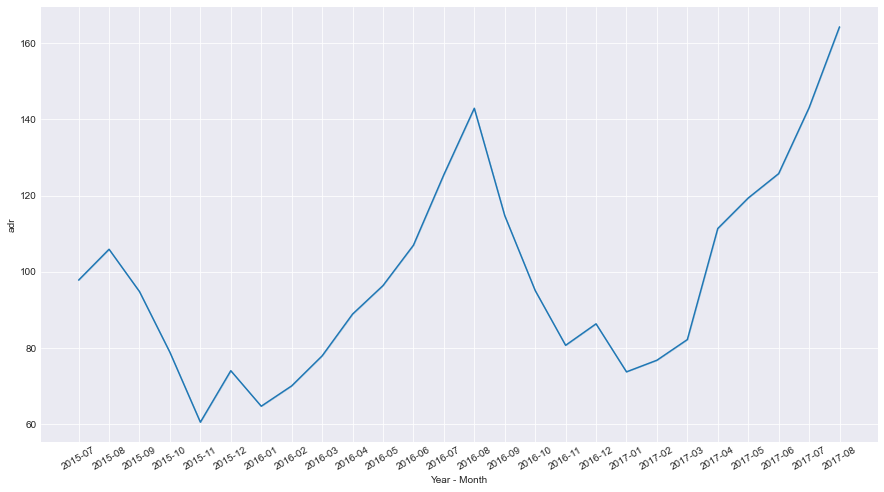

In [68]:
plt.figure(figsize=(15, 8))
sns.lineplot(x='arrival_month',y='adr', data=df, estimator='mean', ci=False)
plt.xlabel('Year - Month')
plt.xticks(fontsize=10, rotation=30)
plt.show()

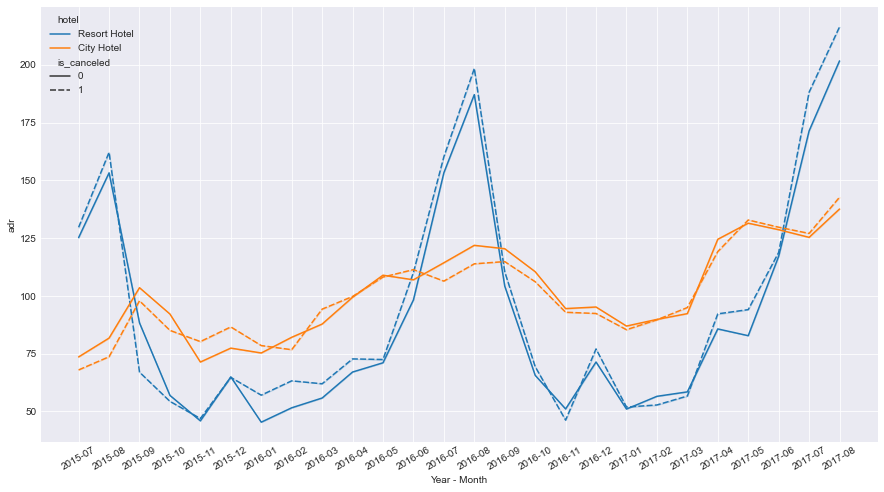

In [69]:
plt.figure(figsize=(15, 8))
sns.lineplot(x='arrival_month',y='adr', data=df, hue='hotel', style='is_canceled', estimator='mean', ci=False)
plt.xlabel('Year - Month')
plt.xticks(fontsize=10, rotation=30)
plt.show()

In [70]:
pd.crosstab(index=df['arrival_month'], columns=[df['hotel'], df['is_canceled']], values=df['adr'], aggfunc='mean', margins=True).round(2).T

arrival_month             2015-07  2015-08  2015-09  2015-10  2015-11  \
hotel        is_canceled                                                
City Hotel   0              73.59    81.74   103.54    92.15    71.39   
             1              67.98    73.67    97.88    85.09    80.23   
Resort Hotel 0             125.22   153.24    88.32    56.95    45.92   
             1             129.68   162.13    67.00    54.36    46.95   
All                         97.83   105.92    94.82    78.90    60.58   

arrival_month             2015-12  2016-01  2016-02  2016-03  2016-04  \
hotel        is_canceled                                                
City Hotel   0              77.40    75.30    82.08    87.81    99.40   
             1              86.58    78.50    76.72    94.27    99.75   
Resort Hotel 0              64.94    45.36    51.58    55.81    67.05   
             1              64.74    57.05    63.24    61.97    72.73   
All                         74.08    64.77    70.10    77.97    88.92   

arrival_month             2016-05  2016-06  2016-07  2016-08  2016-09  \
hotel        is_canceled                                                
City Hotel   0             108.96   106.95   114.33   121.87   120.41   
             1             108.15   111.36   106.40   113.88   114.84   
Resort Hotel 0              71.05    98.25   153.26   187.08   104.25   
             1              72.47   110.11   160.19   198.39   110.42   
All                         96.40   106.98   125.48   142.89   114.75   

arrival_month             2016-10  2016-11  2016-12  2017-01  2017-02  \
hotel        is_canceled                                                
City Hotel   0             110.47    94.51    95.19    86.95    89.83   
             1             106.13    92.91    92.39    85.37    89.65   
Resort Hotel 0              65.64    51.09    71.40    51.03    56.54   
             1              69.39    46.24    77.05    51.91    52.80   
All                         95.11    80.74    86.37    73.78    76.82   

arrival_month             2017-03  2017-04  2017-05  2017-06  2017-07  \
hotel        is_canceled                                                
City Hotel   0              92.32   124.50   131.45   128.65   125.33   
             1              94.96   119.18   132.84   129.72   127.03   
Resort Hotel 0              58.47    85.71    82.78   117.12   171.38   
             1              56.67    92.23    94.05   118.79   188.13   
All                         82.24   111.37   119.37   125.76   143.04   

arrival_month             2017-08     All  
hotel        is_canceled                   
City Hotel   0             137.59  105.75  
             1             142.69  104.53  
Resort Hotel 0             201.68   90.79  
             1             216.39  105.79  
All                        164.25  101.79

Dari Jumlah rerata ADR dapat diketahui:
- Perbandingan tiap bulan - tahun untuk resort hotel tiap bulan Agustus merupakan puncak rerata ADR
- City Hotel juga tiap bulan Agustus mengalami lonjakan rerata ADR yang tinggi
- Tiap bulan Agustus harga selalu naik per ADR nya dibanding bulan lainnya

Secara umum terlihat bahwa jumlah pemesanan sebanding dengan jumlah pemasukan. Namun untuk pada Agustus 2017 terjadi penurunan secara pemesanan namun kenaikan secara jumlah pemasukan

#### - Stays

In [71]:
df['stays'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']

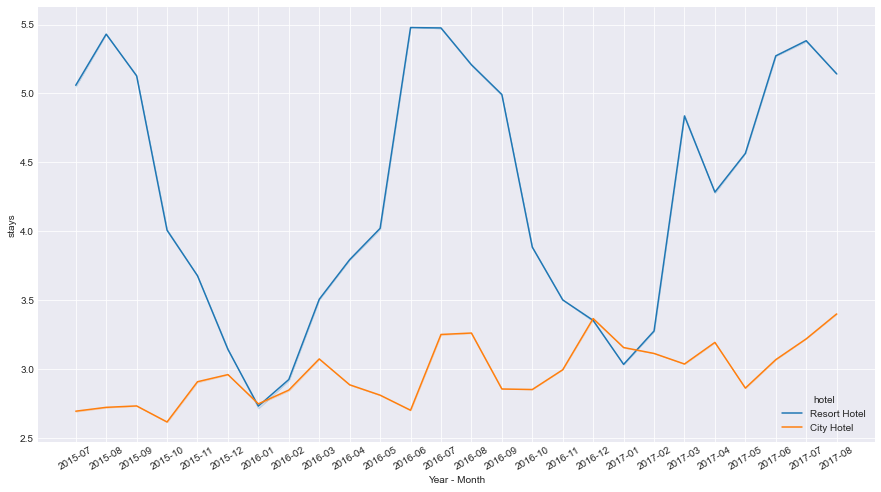

In [72]:
plt.figure(figsize=(15, 8))
sns.lineplot(x='arrival_month',y='stays', data=df, hue='hotel', estimator='mean', ci=False)
plt.xticks(fontsize=10, rotation=30)
plt.xlabel('Year - Month')
plt.show()

In [73]:
pd.crosstab(index=df['arrival_month'], columns=df['hotel'], values=df['stays'], aggfunc='mean', margins=True).round(2).T

arrival_month,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,All
hotel,,,,,,,,,,,,,,,,,,,,,,,,,,,
City Hotel,2.69,2.72,2.73,2.62,2.91,2.96,2.75,2.85,3.07,2.89,2.81,2.70,3.25,3.26,2.85,2.85,2.99,3.37,3.16,3.11,3.04,3.19,2.86,3.07,3.22,3.40,2.98
Resort Hotel,5.06,5.43,5.13,4.01,3.68,3.14,2.73,2.92,3.51,3.79,4.02,5.48,5.48,5.21,4.99,3.88,3.50,3.35,3.03,3.28,4.84,4.28,4.57,5.27,5.38,5.14,4.32
All,3.87,3.70,3.47,3.06,3.27,3.04,2.74,2.88,3.23,3.20,3.21,3.42,3.95,3.91,3.46,3.18,3.15,3.36,3.11,3.17,3.60,3.53,3.34,3.72,3.93,4.04,3.43


In [74]:
pd.crosstab(index=df['arrival_month'], columns=df['hotel'], values=df['stays'], aggfunc='median',margins=True).T

arrival_month,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,All
hotel,,,,,,,,,,,,,,,,,,,,,,,,,,,
City Hotel,2,2,2,2,3,3,2,3,3,3,3,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
Resort Hotel,5,5,4,3,2,3,2,2,3,3,3,5,5,5,4,4,3,3,2,2,3,4,4,5,5,5,3
All,3,3,3,3,3,3,2,2,3,3,3,3,3,3,3,3,3,3,2,3,3,3,3,3,3,4,3


Secara rerata jumlah menginap dapat diketahui:
- Pada tiap bulan Agustus untuk resort hotel mengalami rerata menginap tertinggi yaitu 5 - 5.5
- City Hotel tertinggi pada Juni - Agustus 2016, Desember 2016, dan Agustus 2017
- Bulan Agustus bisa dikatakan merupakan banyak orang untuk menginap dengan durasi yang lama

### *3. Visitors*

#### - Adults

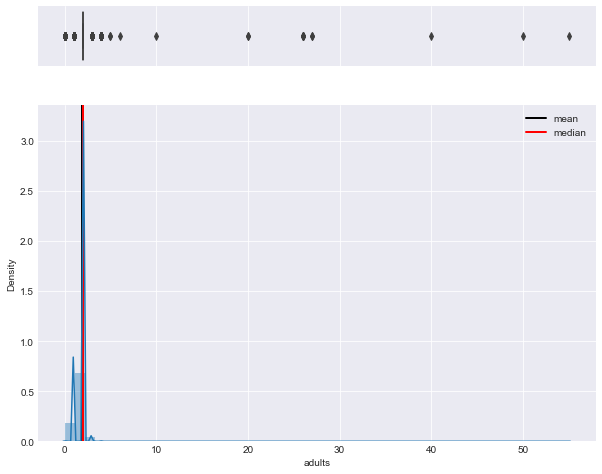

In [75]:
col = df['adults']

# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(figsize=(10,8), nrows=2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
ax_hist.axvline(x=col.mean(), linewidth=2, color = 'k', label='mean') 
ax_hist.axvline(x=col.median(), linewidth=2, color = 'r', label='median')
sns.boxplot(col, ax=ax_box)
sns.distplot(col, ax=ax_hist)

ax_hist.legend()
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
plt.show()

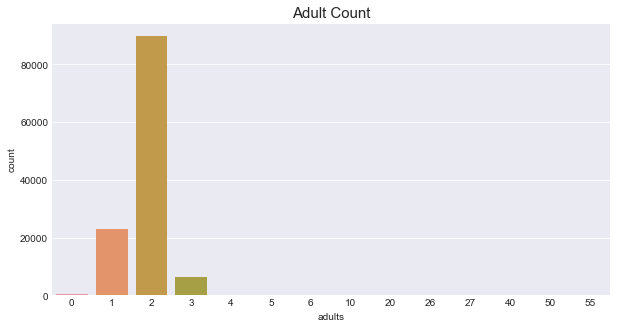

In [76]:
plt.figure(figsize=(10, 5))
plt.title('Adult Count',size=15)
sns.countplot(x='adults', data=df)
plt.xticks(fontsize=10)
plt.show()

In [77]:
data = df['adults'].value_counts().to_frame()
data['percentage'] = (data['adults']*100/data['adults'].sum()).round(2)
data.sort_index()

,adults,percentage
0,403,0.34
1,23027,19.29
2,89679,75.11
3,6202,5.19
4,62,0.05
5,2,0.00
6,1,0.00
10,1,0.00
20,2,0.00
26,5,0.00


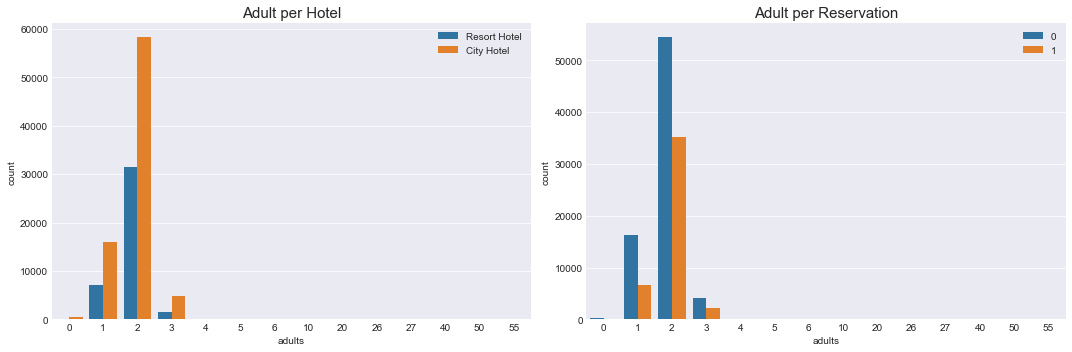

In [78]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.title('Adult per Hotel',size=15)
sns.countplot(x='adults', data=df, hue='hotel')
plt.xticks(fontsize=10)
plt.legend(loc=1)

plt.subplot(122)
plt.title('Adult per Reservation',size=15)
sns.countplot(x='adults', data=df, hue='is_canceled')
plt.xticks(fontsize=10)
plt.legend(loc=1)

plt.tight_layout()
plt.show()

In [79]:
pd.crosstab(index=df['adults'], columns=df['hotel']).T

adults,0,1,2,3,4,5,6,10,20,26,27,40,50,55
hotel,,,,,,,,,,,,,,
City Hotel,390,15879,58254,4775,31,0,0,0,0,0,0,0,0,0
Resort Hotel,13,7148,31425,1427,31,2,1,1,2,5,2,1,1,1


In [80]:
pd.crosstab(index=df['adults'], columns=df['hotel'], normalize=True).mul(100).round(2).T

adults,0,1,2,3,4,5,6,10,20,26,27,40,50,55
hotel,,,,,,,,,,,,,,
City Hotel,0.33,13.30,48.79,4.0,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Resort Hotel,0.01,5.99,26.32,1.2,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [81]:
pd.crosstab(index=df['adults'], columns=df['is_canceled']).T

adults,0,1,2,3,4,5,6,10,20,26,27,40,50,55
is_canceled,,,,,,,,,,,,,,
0,294,16353,54422,4051,46,0,0,0,0,0,0,0,0,0
1,109,6674,35257,2151,16,2,1,1,2,5,2,1,1,1


In [82]:
pd.crosstab(index=df['adults'], columns=df['is_canceled'], normalize=True).mul(100).round(2).T

adults,0,1,2,3,4,5,6,10,20,26,27,40,50,55
is_canceled,,,,,,,,,,,,,,
0,0.25,13.70,45.58,3.39,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.09,5.59,29.53,1.80,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


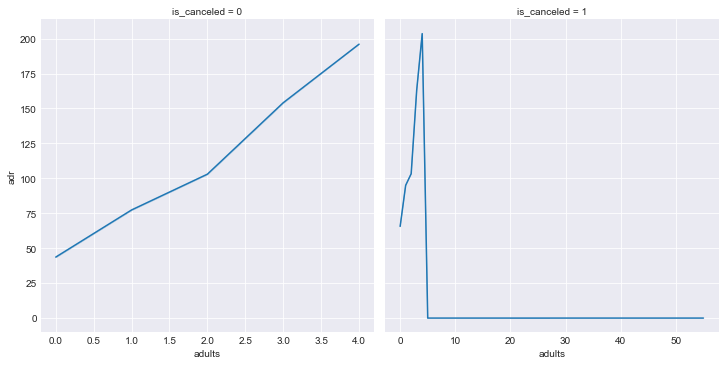

In [83]:
sns.relplot(x='adults', y='adr', data=df, col='is_canceled', kind='line', ci= False, facet_kws=dict(sharex=False))
plt.show()

- Sekitar 75% pemesan terdiri dari 2 dewasa
- Pemesan dengan jumlah adult lebih dari 4 semuanya melakukan pembatalan pemesanan dan memesan jenis hotel Resort

#### - Children

In [84]:
df_c = df.copy()

In [85]:
len(df_c[df_c['children'].isna()==False])/len(df_c)

0.9999664960758529

In [86]:
df_c = df_c[df_c['children'].isna()==False]

In [87]:
(len(df[df['children'] != 0])/len(df))*100

7.198318103007814

Sekitar 7.2% data tersebut yang terdapat children

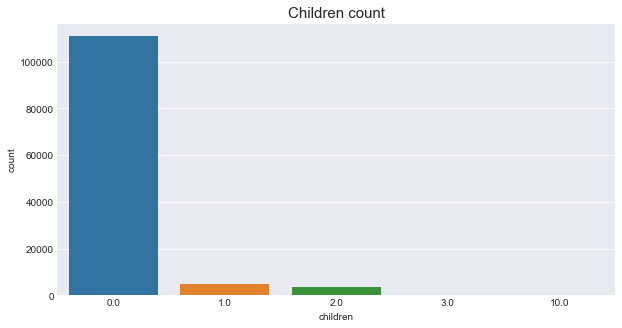

In [88]:
plt.figure(figsize=(10, 5))
plt.title('Children count',size=15)
sns.countplot(x='children', data=df)
plt.xticks(fontsize=10)
plt.show()

In [89]:
data = df['children'].value_counts().to_frame()
data['percentage'] = (data['children']*100/data['children'].sum()).round(2)
data.sort_index()

,children,percentage
0.0,110795,92.80
1.0,4861,4.07
2.0,3652,3.06
3.0,76,0.06
10.0,1,0.00


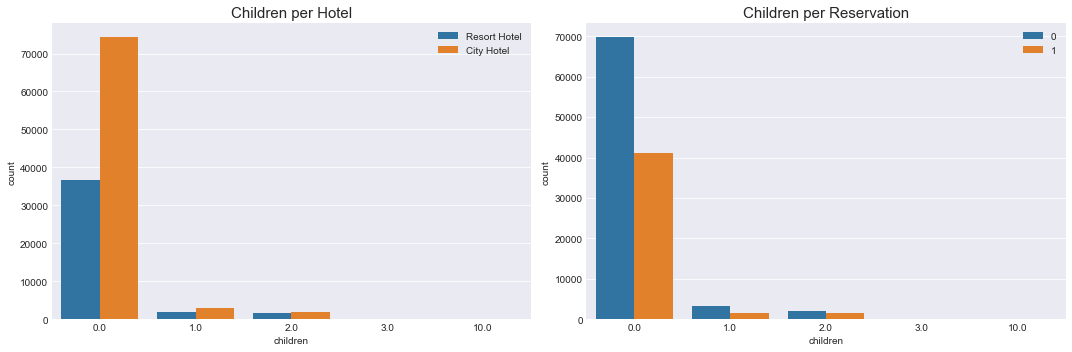

In [90]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.title('Children per Hotel',size=15)
sns.countplot(x='children', data=df, hue='hotel')
plt.xticks(fontsize=10)
plt.legend(loc=1)

plt.subplot(122)
plt.title('Children per Reservation',size=15)
sns.countplot(x='children', data=df, hue='is_canceled')
plt.xticks(fontsize=10)
plt.legend(loc=1)

plt.tight_layout()
plt.show()

In [91]:
pd.crosstab(index=df['children'], columns=df['hotel']).T

children,0.0,1.0,2.0,3.0,10.0
hotel,,,,,
City Hotel,74219,3023,2024,59,0
Resort Hotel,36576,1838,1628,17,1


In [92]:
(pd.crosstab(index=df['children'], columns=df['hotel'], normalize=True)*100).round(2).T

children,0.0,1.0,2.0,3.0,10.0
hotel,,,,,
City Hotel,62.17,2.53,1.70,0.05,0.0
Resort Hotel,30.64,1.54,1.36,0.01,0.0


In [93]:
pd.crosstab(index=df['children'], columns=df['is_canceled']).T

children,0.0,1.0,2.0,3.0,10.0
is_canceled,,,,,
0,69702,3294,2111,59,0
1,41093,1567,1541,17,1


In [94]:
(pd.crosstab(index=df['children'], columns=df['is_canceled'], normalize=True)*100).round(2).T

children,0.0,1.0,2.0,3.0,10.0
is_canceled,,,,,
0,58.38,2.76,1.77,0.05,0.0
1,34.42,1.31,1.29,0.01,0.0


In [95]:
df[df['children'] > 3]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date,arrival_month,stays
328,Resort Hotel,1,55,2015,July,29,12,4,10,2,10.0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,D,D,2,No Deposit,8.0,NaN,0,Contract,133.16,0,1,No-Show,2015-07-12,2015-07-12,2015-07,14


Terlihat terdapat yang transaksi dengan tamu anak berjumlah 10, bisa dikatakan itu merupakan sebuah kelompok atau bisa dikatakan sebuah keluarga, mengingat memungkinkan anak berjumlah 10

- 92.8% pemesanan tanpa ada children
- 7.2% pemesanan terdapat children
- Terdapat 1 pemesanan berjumlah 10 children, bisa dikatakan sebuah keluarga, namum pemesanan di batalkan

#### - Baby

In [96]:
(len(df[df['babies'] != 0])/len(df))*100

0.7680774610726282

Sekitar 0.8% data tersebut terdapat bayi

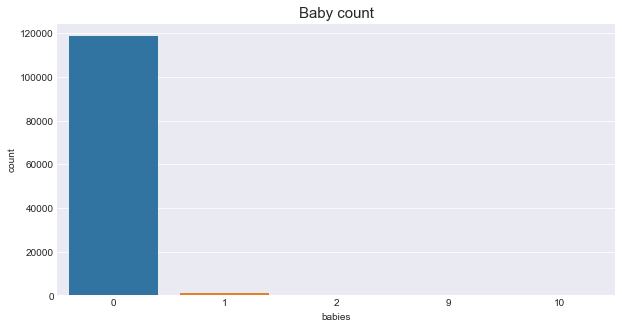

In [97]:
plt.figure(figsize=(10, 5))
plt.title('Baby count',size=15)
sns.countplot(x='babies', data=df)
plt.xticks(fontsize=10)
plt.show()

In [98]:
data = df['babies'].value_counts().to_frame()
data['percentage'] = (data['babies']*100/data['babies'].sum()).round(2)
data.sort_index()

,babies,percentage
0,118472,99.23
1,900,0.75
2,15,0.01
9,1,0.00
10,1,0.00


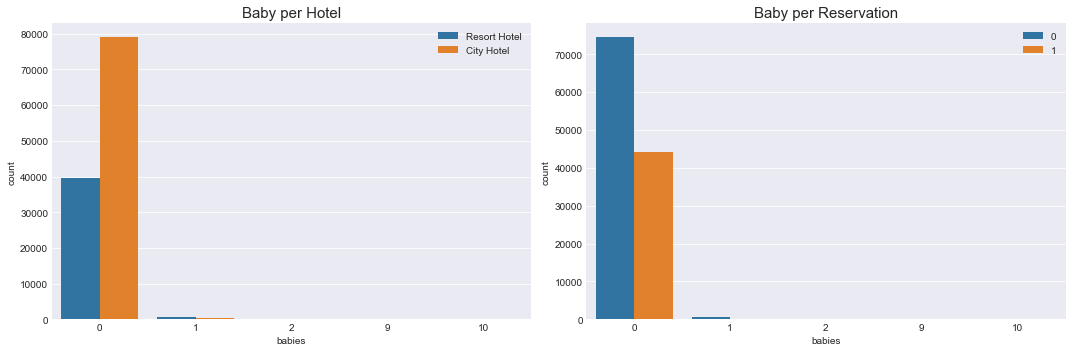

In [99]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.title('Baby per Hotel',size=15)
sns.countplot(x='babies', data=df, hue='hotel')
plt.xticks(fontsize=10)
plt.legend(loc=1)

plt.subplot(122)
plt.title('Baby per Reservation',size=15)
sns.countplot(x='babies', data=df, hue='is_canceled')
plt.xticks(fontsize=10)
plt.legend(loc=1)

plt.tight_layout()
plt.show()

In [100]:
pd.crosstab(index=df['babies'], columns=df['hotel']).T

babies,0,1,2,9,10
hotel,,,,,
City Hotel,78960,361,6,1,1
Resort Hotel,39512,539,9,0,0


In [101]:
(pd.crosstab(index=df['babies'], columns=df['hotel'],  normalize=True)*100).round(2).T

babies,0,1,2,9,10
hotel,,,,,
City Hotel,66.14,0.30,0.01,0.0,0.0
Resort Hotel,33.10,0.45,0.01,0.0,0.0


In [102]:
pd.crosstab(index=df['babies'], columns=df['is_canceled']).T

babies,0,1,2,9,10
is_canceled,,,,,
0,74416,735,13,1,1
1,44056,165,2,0,0


In [103]:
(pd.crosstab(index=df['babies'], columns=df['is_canceled'], normalize=True)*100).round(2).T

babies,0,1,2,9,10
is_canceled,,,,,
0,62.33,0.62,0.01,0.0,0.0
1,36.90,0.14,0.00,0.0,0.0


In [104]:
df[df['babies'] > 3]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date,arrival_month,stays
46619,City Hotel,0,37,2016,January,3,12,0,2,2,0.0,10,BB,PRT,Online TA,TA/TO,0,0,0,D,D,1,No Deposit,9.0,NaN,0,Transient,84.45,0,1,Check-Out,2016-01-14,2016-01-12,2016-01,2
78656,City Hotel,0,11,2015,October,42,11,2,1,1,0.0,9,BB,GBR,Corporate,Corporate,0,0,0,A,B,1,No Deposit,95.0,NaN,0,Transient-Party,95.00,0,0,Check-Out,2015-10-14,2015-10-11,2015-10,3


Bisa dikatakan bayi berjumlah banyak bisa dikatakan bahwa hal itu masuk dalam kelompok. akan tetapi bisa keluarga antara kembar namun itu sangat jarang sekali

- 99.2% merupakan tidak membawa bayi
- 0.8% membawa bayi
- Bayi diatas 3 tidak melakukan pembatalan dan bisa dianggap sebuah keluarga

#### - Family

In [105]:
df[(df['children'] == 0) & (df['babies'] != 0)][['adults','children','babies']].head(5)

,adults,children,babies
109,2,0.0,1
111,2,0.0,1
165,2,0.0,1
236,2,0.0,1
264,2,0.0,2


In [106]:
df[(df['children'] != 0) & (df['babies'] == 0)][['adults','children','babies']].head(5)

,adults,children,babies
13,2,1.0,0
45,2,2.0,0
55,2,2.0,0
65,2,2.0,0
87,2,1.0,0


Kolom children tidak merepresentasikan babies dan sebaliknya, terlihat bahwa children merupakan jumlah dari kolom babies dan sebaliknya, karena ada data untuk children 0 tetapi babies 1 dan sebaliknya, kalau berhubungan seharusnya tidak ada data seperti itu. Seharusnya jika berhubungan walaupun babies 1 children juga minimal ada 1.

In [107]:
df['kids'] = df['babies'] + df['children']
df.head(5)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date,arrival_month,stays,kids
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-07-01,2015-07,0,0.0
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-07-01,2015-07,0,0.0
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01,2015-07,1,0.0
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01,2015-07,1,0.0
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03,2015-07-01,2015-07,2,0.0


In [108]:
(len(df[df['kids'] != 0])/len(df))*100

7.819815895936812

Sekitar 7.8% transaksi terdapat anak

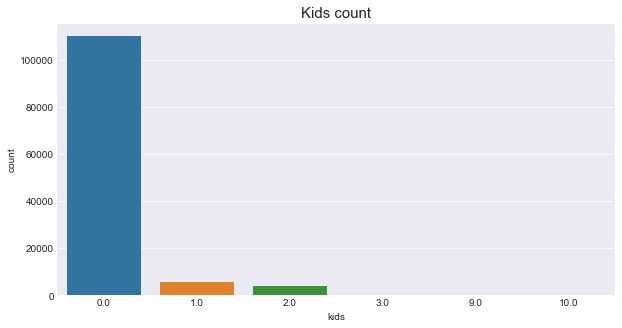

In [109]:
plt.figure(figsize=(10, 5))
plt.title('Kids count',size=15)
sns.countplot(x='kids', data=df)
plt.xticks(fontsize=10)
plt.show()

In [110]:
col = df['kids']
pd.DataFrame(np.array([
    col.value_counts(sort=False),
    col.value_counts(sort=False, normalize=True).mul(100).round(2)]).T,
            index=col.value_counts(sort=False).index,
            columns=['Sum','Percent']).sort_index()

,Sum,Percent
0.0,110053.0,92.18
1.0,5446.0,4.56
2.0,3772.0,3.16
3.0,111.0,0.09
9.0,1.0,0.00
10.0,2.0,0.00


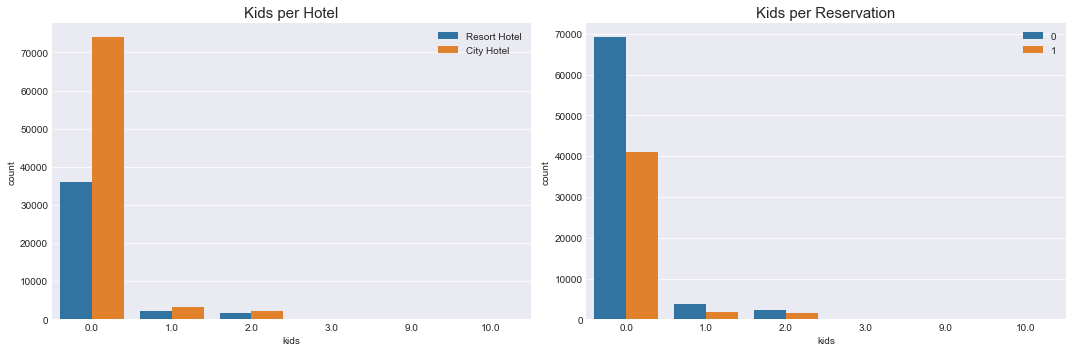

In [111]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.title('Kids per Hotel',size=15)
sns.countplot(x='kids', data=df, hue='hotel')
plt.xticks(fontsize=10)
plt.legend(loc=1)

plt.subplot(122)
plt.title('Kids per Reservation',size=15)
sns.countplot(x='kids', data=df, hue='is_canceled')
plt.xticks(fontsize=10)
plt.legend(loc=1)

plt.tight_layout()
plt.show()

In [112]:
pd.crosstab(index=df['kids'], columns=df['hotel'], values=df['hotel'], aggfunc='count', dropna=True).T

kids,0.0,1.0,2.0,3.0,9.0,10.0
hotel,,,,,,
City Hotel,73922.0,3263.0,2056.0,82.0,1.0,1.0
Resort Hotel,36131.0,2183.0,1716.0,29.0,NaN,1.0


In [113]:
(pd.crosstab(index=df['kids'], columns=df['hotel'], values=df['hotel'], aggfunc='count', dropna=True, normalize=True)*100).round(2).T

kids,0.0,1.0,2.0,3.0,9.0,10.0
hotel,,,,,,
City Hotel,61.92,2.73,1.72,0.07,0.0,0.0
Resort Hotel,30.26,1.83,1.44,0.02,0.0,0.0


In [114]:
pd.crosstab(index=df['kids'], columns=df['is_canceled'], values=df['is_canceled'], aggfunc='count').T

kids,0.0,1.0,2.0,3.0,9.0,10.0
is_canceled,,,,,,
0,69093.0,3769.0,2221.0,81.0,1.0,1.0
1,40960.0,1677.0,1551.0,30.0,NaN,1.0


In [115]:
(pd.crosstab(index=df['kids'], columns=df['is_canceled'], values=df['is_canceled'], aggfunc='count', dropna=True, normalize=True)*100).round(2).T

kids,0.0,1.0,2.0,3.0,9.0,10.0
is_canceled,,,,,,
0,57.87,3.16,1.86,0.07,0.0,0.0
1,34.31,1.40,1.30,0.03,0.0,0.0


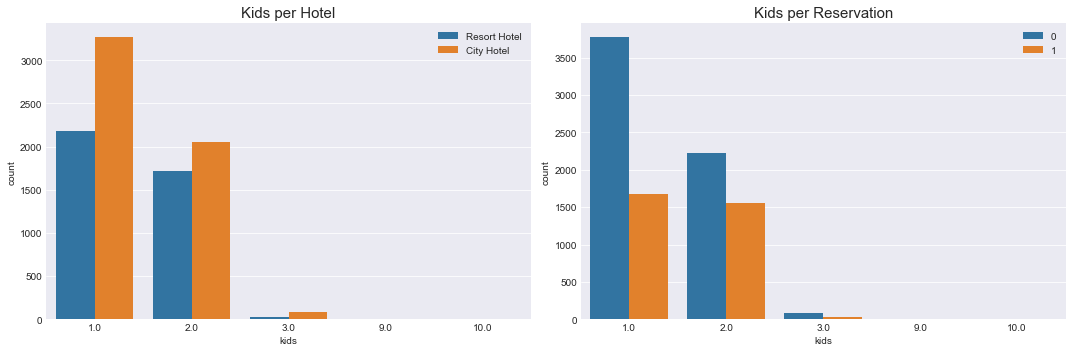

In [116]:
data = df[df['kids'] != 0]

plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.title('Kids per Hotel',size=15)
sns.countplot(x='kids', data=data, hue='hotel')
plt.xticks(fontsize=10)
plt.legend(loc=1)

plt.subplot(122)
plt.title('Kids per Reservation',size=15)
sns.countplot(x='kids', data=data, hue='is_canceled')
plt.xticks(fontsize=10)
plt.legend(loc=1)

plt.tight_layout()
plt.show()

In [117]:
pd.crosstab(index=data['kids'], columns=data['hotel'], values=data['hotel'], aggfunc='count', dropna=True).T

kids,1.0,2.0,3.0,9.0,10.0
hotel,,,,,
City Hotel,3263.0,2056.0,82.0,1.0,1.0
Resort Hotel,2183.0,1716.0,29.0,NaN,1.0


In [118]:
(pd.crosstab(index=data['kids'], columns=data['hotel'], values=data['hotel'], aggfunc='count', dropna=True, normalize=True)*100).round(2).T

kids,1.0,2.0,3.0,9.0,10.0
hotel,,,,,
City Hotel,34.97,22.03,0.88,0.01,0.01
Resort Hotel,23.39,18.39,0.31,0.00,0.01


In [119]:
pd.crosstab(index=data['kids'], columns=data['is_canceled'], values=data['is_canceled'], aggfunc='count').T

kids,1.0,2.0,3.0,9.0,10.0
is_canceled,,,,,
0,3769.0,2221.0,81.0,1.0,1.0
1,1677.0,1551.0,30.0,NaN,1.0


In [120]:
(pd.crosstab(index=data['kids'], columns=data['is_canceled'], values=data['is_canceled'], aggfunc='count', dropna=True, normalize=True)*100).round(2).T

kids,1.0,2.0,3.0,9.0,10.0
is_canceled,,,,,
0,40.39,23.80,0.87,0.01,0.01
1,17.97,16.62,0.32,0.00,0.01


Seseorang yang mempunyai anak dan bayi pasti merupakan sebuah keluarga. Bisa disimpulkan bahwa kolom kids juga merepresentasikan apakah transaksi tersebut bersama keluarga atau tidak, lebih tepatnya keluarga secara umum yang memiliki anak. Walaupun orang yang tidak memiliki anak juga bisa dikatakan keluarga. Namun kemungkinan besar itu merupakan sebuah pasangan muda atau baru menikah, dan dengan kolom kids ini merepresentasikan bahwa transaksi tersebut merupakan sebuah keluarga.

In [121]:
df['family'] = df['kids'].apply(lambda x: 0 if x == 0 else 1)

In [122]:
df.head(5)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date,arrival_month,stays,kids,family
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-07-01,2015-07,0,0.0,0
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-07-01,2015-07,0,0.0,0
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01,2015-07,1,0.0,0
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01,2015-07,1,0.0,0
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03,2015-07-01,2015-07,2,0.0,0


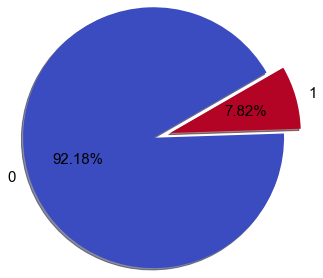

In [123]:
kolom = df['family']
persen = []
nama = []
for i in kolom.unique():
    nama.append(i)
    persen.append(len(df[kolom == i]))
    
cmap = plt.get_cmap('coolwarm')
warna = [cmap(i) for i in np.linspace(0, 1, len(nama))]

plt.pie(
    persen,
    labels=nama,
    colors=warna,
    startangle=30,
    shadow=True,
    radius=1.5,
    textprops={
        'size' : 15,
        'color' : 'k'
    },
    autopct='%1.2f%%',
    explode=(.1, .1)
    )
plt.show()

- 92.18% tidak membawa anak anak atau dibawah umur
- 7.82% membawa anak anak
- membawa anak-anak dapat direpresentasikan merupakan sebuah keluarga secara komplit atau pasangan yang mempunyai anak

#### - Country

In [124]:
data = df['country'].value_counts().to_frame()
data['percent'] = (data['country']/data['country'].sum()).mul(100).round(2)
data['cumpercentage'] = (data['country'].cumsum()/data['country'].sum()).mul(100).round(2)
data

,country,percent,cumpercentage
PRT,48589,40.87,40.87
GBR,12129,10.20,51.07
FRA,10415,8.76,59.83
ESP,8568,7.21,67.03
DEU,7287,6.13,73.16
...,...,...,...
NPL,1,0.00,100.00
MDG,1,0.00,100.00
ASM,1,0.00,100.00
BHS,1,0.00,100.00


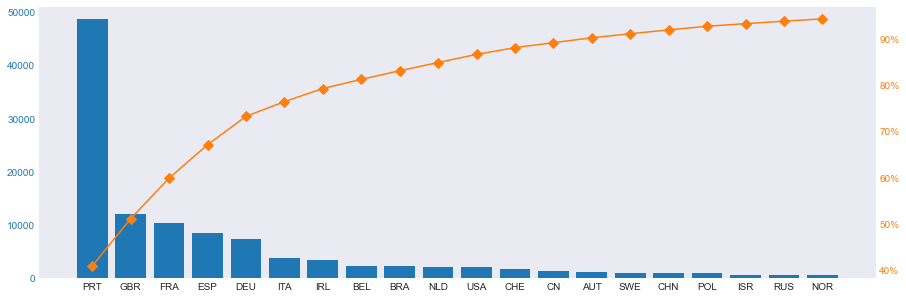

In [125]:
from matplotlib.ticker import PercentFormatter
data = data.head(20)

fig, ax = plt.subplots(figsize=(15,5))
ax.bar(data.index, data["country"], color="C0")
ax2 = ax.twinx()
ax2.plot(data.index, data["cumpercentage"], color="C1", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())

ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")
ax.grid(False)
ax2.grid(False)
plt.show()

In [135]:
data1 = df[df['country'].isin(data.index[:21])]

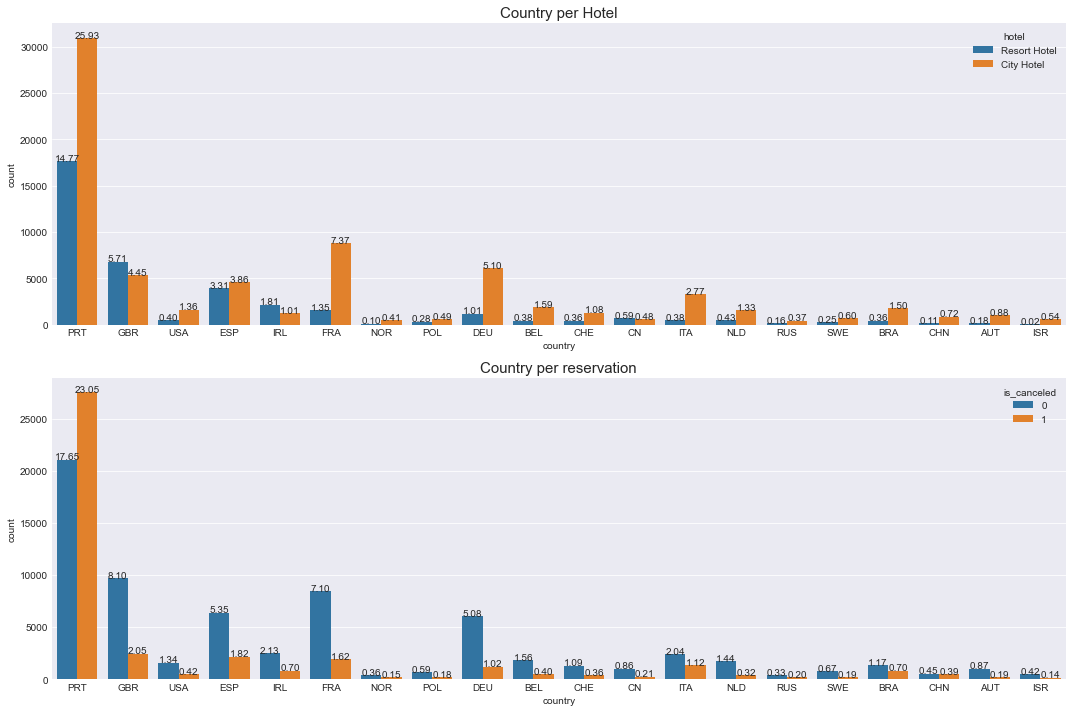

In [136]:
total = float(len(df))
plt.figure(figsize=(15, 10))

plt.subplot(211)
plt.title('Country per Hotel',size=15)
ax = sns.countplot(x='country', data=data1, hue='hotel')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format((height/total)*100),
            ha="center")

plt.subplot(212)
plt.title('Country per reservation',size=15)
ax = sns.countplot(x='country', data=data1, hue='is_canceled')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format((height/total)*100),
            ha="center")
    
plt.tight_layout()
plt.show()

In [137]:
data2 = df[['is_canceled','hotel']]
data2['from'] = df['country'].apply(lambda x:'Domestic' if x=='PRT' else 'Inter' )

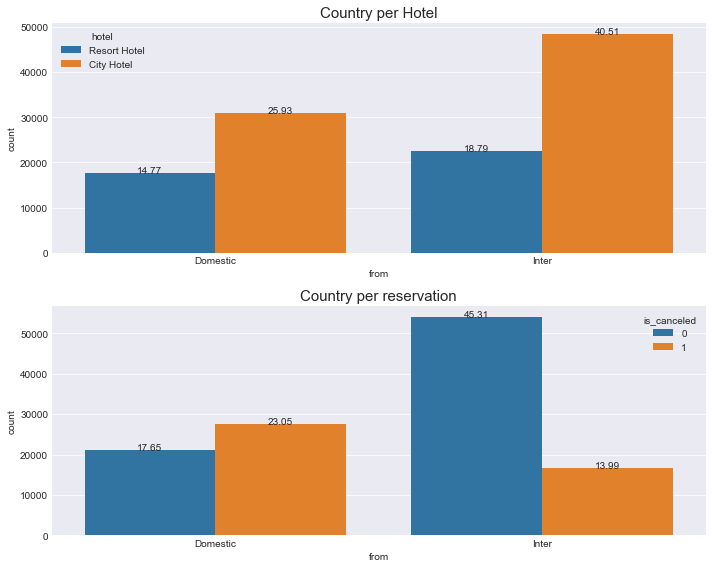

In [138]:
total = float(len(df))
plt.figure(figsize=(10,8))

plt.subplot(211)
plt.title('Country per Hotel',size=15)
ax = sns.countplot(x='from', data=data2, hue='hotel')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format((height/total)*100),
            ha="center")

plt.subplot(212)
plt.title('Country per reservation',size=15)
ax = sns.countplot(x='from', data=data2, hue='is_canceled')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format((height/total)*100),
            ha="center")
    
plt.tight_layout()
plt.show()

- Transaksi terdiri dari 40.9% berasal dari dalam negeri (PRT) dan sedangkan sisanya berasal dari luar negeri
- Terlihat untuk berdasarkan jenis hotel banyak dari luar atau dalam negeri yang memilih city hotel
- Untuk pemesanan terlihat bahwa dari dalam negeri banyak yang melakukan pembatalan dibandingkan dengan luar negeri yang tidak membatalkan pemesanan

### *4. Market Segmentation*

#### - Market Segment

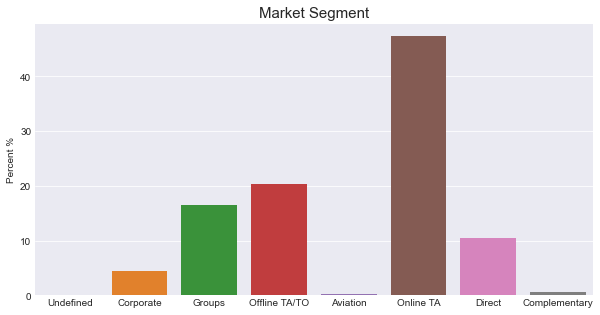

In [139]:
data = df['market_segment'].value_counts(normalize=True, sort=False).mul(100).round(2)

plt.figure(figsize=(10, 5))
plt.title('Market Segment',size=15)
sns.barplot(x=data.index, y=data)
plt.ylabel('Percent %')
plt.xticks(fontsize=10)
plt.show()

In [140]:
col = df['market_segment']
pd.DataFrame(np.array([
    col.value_counts(sort=False),
    col.value_counts(sort=False, normalize=True).mul(100).round(2)]).T,
            index=col.value_counts(sort=False).index,
            columns=['Sum','Percent'])

,Sum,Percent
Undefined,2.0,0.00
Corporate,5295.0,4.44
Groups,19811.0,16.59
Offline TA/TO,24218.0,20.28
Aviation,237.0,0.20
Online TA,56477.0,47.31
Direct,12606.0,10.56
Complementary,743.0,0.62


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


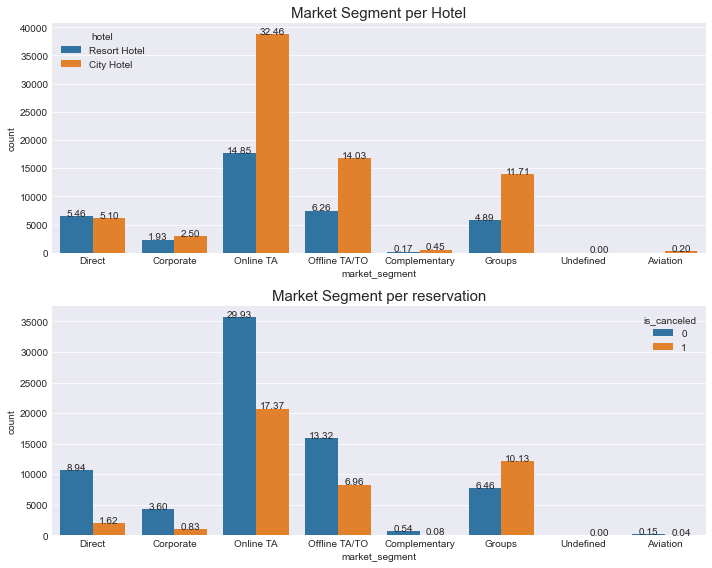

In [141]:
total = float(len(df))
plt.figure(figsize=(10,8))

plt.subplot(211)
plt.title('Market Segment per Hotel',size=15)
ax = sns.countplot(x='market_segment', data=df, hue='hotel')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format((height/total)*100),
            ha="center")

plt.subplot(212)
plt.title('Market Segment per reservation',size=15)
ax = sns.countplot(x='market_segment', data=df, hue='is_canceled')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format((height/total)*100),
            ha="center")
    
plt.tight_layout()
plt.show()

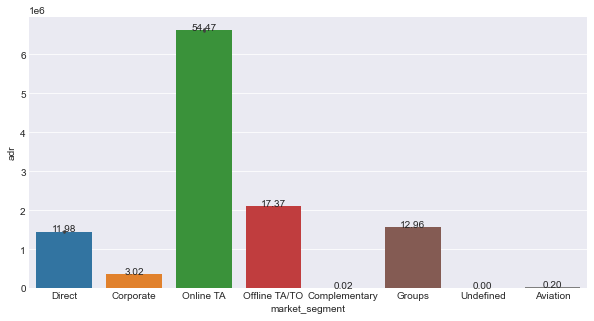

In [142]:
plt.figure(figsize=(10,5))
ax = sns.barplot(x='market_segment', y='adr', data=df, estimator=sum)
total = df['adr'].sum()
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format((height/total)*100),
            ha="center")
    
plt.show()

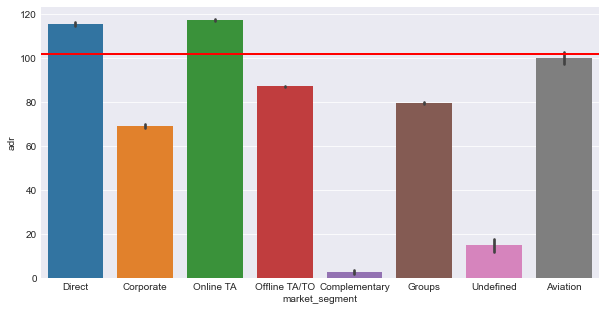

In [143]:
plt.figure(figsize=(10,5))
sns.barplot(x='market_segment', y='adr', data=df)
plt.axhline(y=df['adr'].mean(), linewidth=2, color = 'r', label='mean')
plt.show()

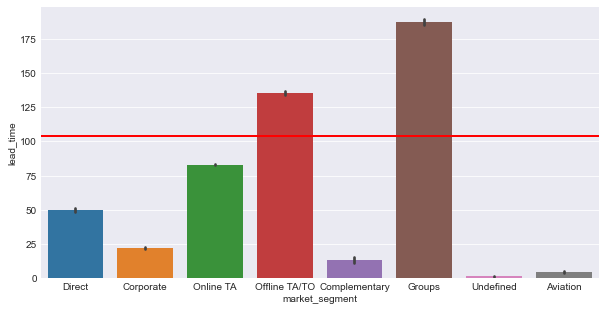

In [144]:
plt.figure(figsize=(10,5))
sns.barplot(x='market_segment', y='lead_time', data=df)
plt.axhline(y=df['lead_time'].mean(), linewidth=2, color = 'r', label='mean')
plt.show()

- Banyak pemesan secara OTA atau Online Travel Agency, karena sudah cukup wajar dengan banyak platform booking via internet yang makin banyak
- Pemesanan melalui TA/TO baik offline dan online masih sangat diminati dibanding yang lain terlihat dari jumlah serta jumlah adr yang didapat dibandingkan dengan yang lain
- Perbandingan antara jenis hotel untuk market segment tidak terlalu berbeda atau sama seperti proporsi data yang banyak dari City Hotel
- Untuk pembatalan terlihat bahwa Groups banyak membatalkan dibandingkan dengan tidak membatalkan
- Aviation, Undefined dan Complementary merupakan pemesanan dengan tenggat waktu dari memesan dengan menggunakan hotel sangat kecil sekali atau bisa dibilang memesan dengan menggunakan dengan jarak waktu yang singkat sekali
- Aviation adr tinggi dikarenakan lead time yang sedikit dengan kebutuhan hotel sesegera mungkin akibat dari delay nya penerbangan

#### - Distribution Channel

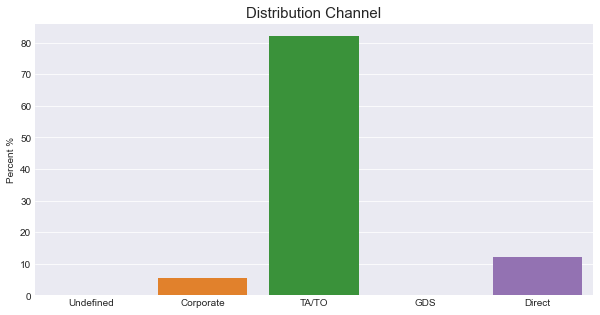

In [145]:
data = df['distribution_channel'].value_counts(normalize=True, sort=False).mul(100).round(2)

plt.figure(figsize=(10, 5))
plt.title('Distribution Channel',size=15)
sns.barplot(x=data.index, y=data)
plt.ylabel('Percent %')
plt.xticks(fontsize=10)
plt.show()

In [146]:
col = df['distribution_channel']
pd.DataFrame(np.array([
    col.value_counts(sort=False),
    col.value_counts(sort=False, normalize=True).mul(100).round(2)]).T,
            index=col.value_counts(sort=False).index,
            columns=['Sum','Percent'])

,Sum,Percent
Undefined,5.0,0.00
Corporate,6677.0,5.59
TA/TO,97869.0,81.97
GDS,193.0,0.16
Direct,14645.0,12.27


posx and posy should be finite values
posx and posy should be finite values


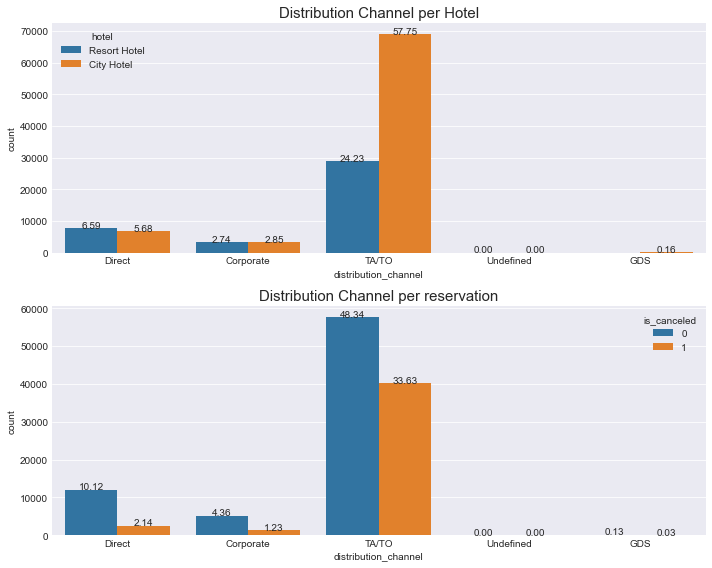

In [147]:
total = float(len(df))
plt.figure(figsize=(10,8))

plt.subplot(211)
plt.title('Distribution Channel per Hotel',size=15)
ax = sns.countplot(x='distribution_channel', data=df, hue='hotel')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format((height/total)*100),
            ha="center")

plt.subplot(212)
plt.title('Distribution Channel per reservation',size=15)
ax = sns.countplot(x='distribution_channel', data=df, hue='is_canceled')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format((height/total)*100),
            ha="center")
    
plt.tight_layout()
plt.show()

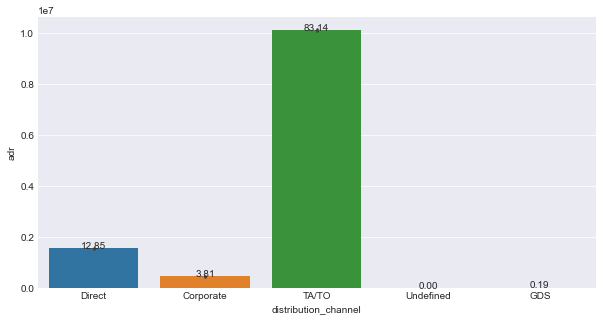

In [148]:
plt.figure(figsize=(10,5))
ax = sns.barplot(x='distribution_channel', y='adr', data=df, estimator=sum)
total = df['adr'].sum()
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format((height/total)*100),
            ha="center")
    
plt.show()

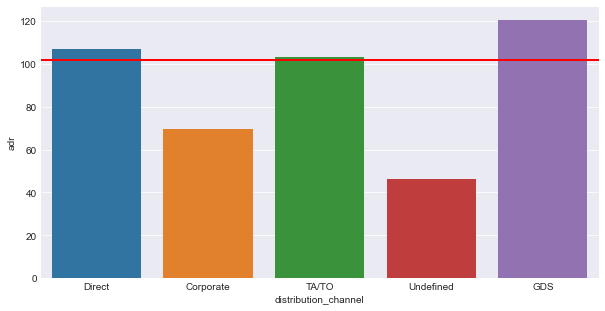

In [149]:
plt.figure(figsize=(10,5))
sns.barplot(x='distribution_channel', y='adr', data=df, ci=False)
plt.axhline(y=df['adr'].mean(), linewidth=2, color = 'r', label='mean')
plt.show()

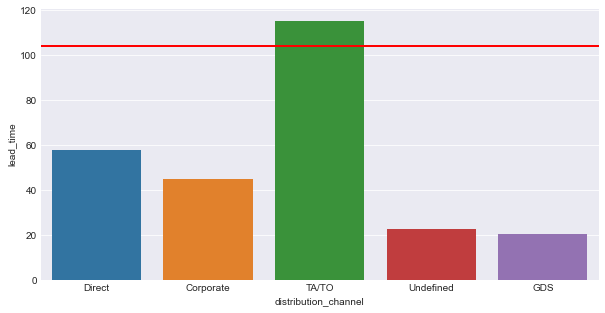

In [150]:
plt.figure(figsize=(10,5))
sns.barplot(x='distribution_channel', y='lead_time', data=df, ci=False)
plt.axhline(y=df['lead_time'].mean(), linewidth=2, color = 'r', label='mean')
plt.show()

- Banyak melakukan pemesanan melalui TA/TO terlihat dari jumlah pemesanan dan jumlah adr dibandingkan dengan pemesanan yang ain
- Pemesanan TA/TO didominasi dari City Hotel disusul dengan Resort Hotel
- GDS merupakan rerata adr tertinggi dibandingkan dengan yang lain dengan terlihat lead_time atau jarak antara reservasi dengan menggunakan hotel sanga kecil dibandingkan dengan yang lain
- Pemesan melalui TA/TO memesan jauh jauh hari dibandingkan dengan yang lain

#### - Segment X Distribution

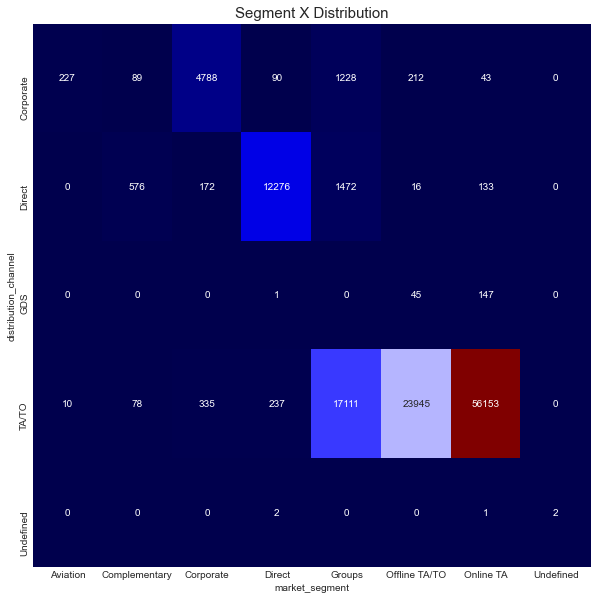

In [151]:
plt.figure(figsize=[10,10])
plt.title('Segment X Distribution', size=15)
sns.heatmap((pd.crosstab(df['distribution_channel'], df['market_segment'])),
            cmap="seismic", annot=True, cbar=False, fmt='d')
plt.show()

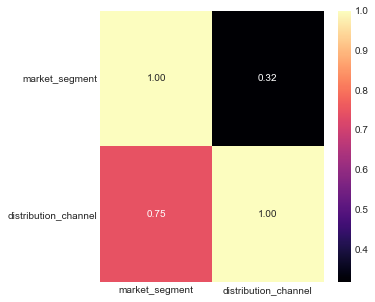

In [152]:
data = df[['market_segment','distribution_channel']]

theilu = pd.DataFrame(index=data.columns,columns=data.columns)
columns = data.columns
for i in columns:
    for j in range(0,len(columns)):
        u = theil_u(data[i].tolist(),data[columns[j]].tolist())
        theilu.loc[i,columns[j]] = u
theilu.fillna(value=np.nan,inplace=True)
plt.figure(figsize=(5,5))
sns.heatmap(theilu,annot=True,fmt='.2f',cmap='magma')
plt.yticks(rotation=0)
plt.show()

- Distribusi atau penjualan melalui TA/TO banyak diminati dari segment Online TA, Offline TA/TO dan Groups
- Banyak kesamaan dari distribusi dan segment untuk Direct dan Corporate
- 1 Undefined ternyata merupakan Online TA yang dapat dimasukkan ke dalam TA/TO
- Korelasi dengan menggunakan theil'u memeperlihatkan bahwa distribution_channel dapat mewakili dari market segment. sedangkan market segment tidak dapat mewakili distribution_channel

#### - Deposit Type

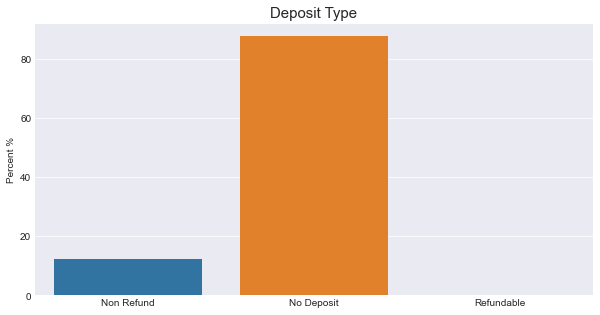

In [153]:
data = df['deposit_type'].value_counts(normalize=True, sort=False).mul(100).round(2)

plt.figure(figsize=(10, 5))
plt.title('Deposit Type',size=15)
sns.barplot(x=data.index, y=data)
plt.ylabel('Percent %')
plt.xticks(fontsize=10)
plt.show()

In [154]:
col = df['deposit_type']
pd.DataFrame(np.array([
    col.value_counts(sort=False),
    col.value_counts(sort=False, normalize=True).mul(100).round(2)]).T,
            index=col.value_counts(sort=False).index,
            columns=['Sum','Percent'])

,Sum,Percent
Non Refund,14586.0,12.22
No Deposit,104641.0,87.65
Refundable,162.0,0.14


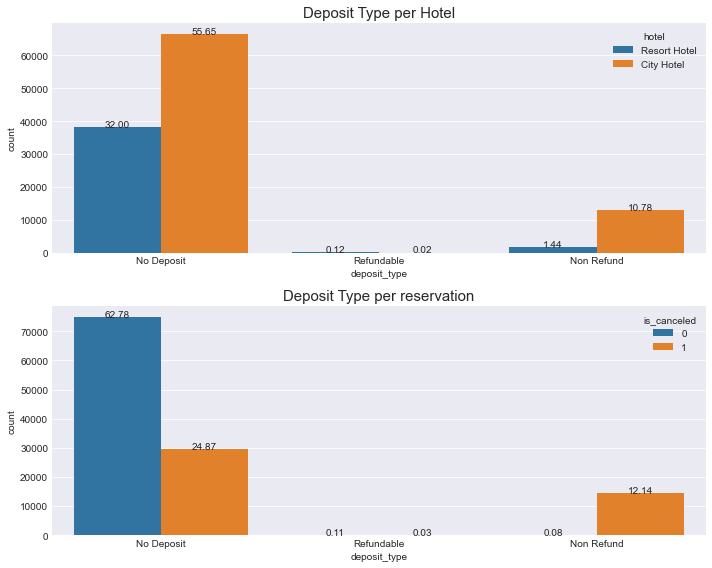

In [155]:
total = float(len(df))
plt.figure(figsize=(10,8))

plt.subplot(211)
plt.title('Deposit Type per Hotel',size=15)
ax = sns.countplot(x='deposit_type', data=df, hue='hotel')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format((height/total)*100),
            ha="center")

plt.subplot(212)
plt.title('Deposit Type per reservation',size=15)
ax = sns.countplot(x='deposit_type', data=df, hue='is_canceled')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format((height/total)*100),
            ha="center")
    
plt.tight_layout()
plt.show()

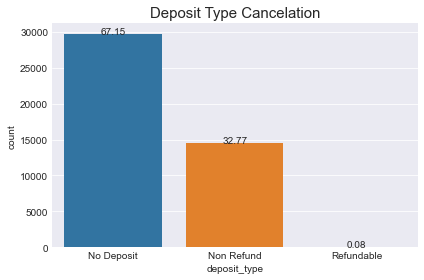

In [156]:
data = df[df['is_canceled'] == 1]
total = float(len(data))
plt.title('Deposit Type Cancelation',size=15)
ax = sns.countplot(x='deposit_type', data=data)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format((height/total)*100),
            ha="center")
    
plt.tight_layout()

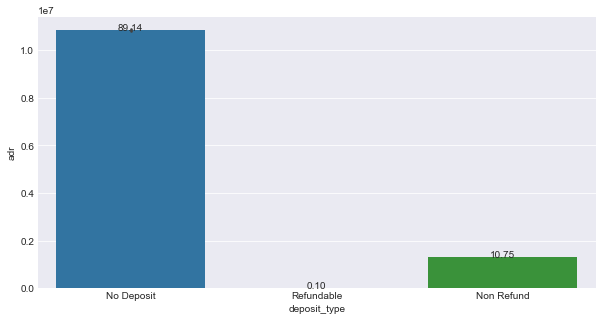

In [157]:
plt.figure(figsize=(10,5))
ax = sns.barplot(x='deposit_type', y='adr', data=df, estimator=sum)
total = df['adr'].sum()
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format((height/total)*100),
            ha="center")
    
plt.show()

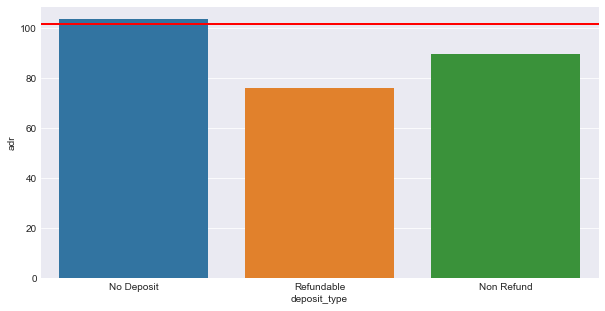

In [158]:
plt.figure(figsize=(10,5))
sns.barplot(x='deposit_type', y='adr', data=df, ci=False)
plt.axhline(y=df['adr'].mean(), linewidth=2, color = 'r', label='mean')
plt.show()

- Hampir 88% orang melakukan pemesanan tidak menggunakan deposit
- Sekitar 67,4% tidak deposit membatalkan pesanan dibanding dengan yang lain
- Namun untuk rerata ADR no deposit lebih besar dibanding dengan menggunakan deposit

#### - Customer Type

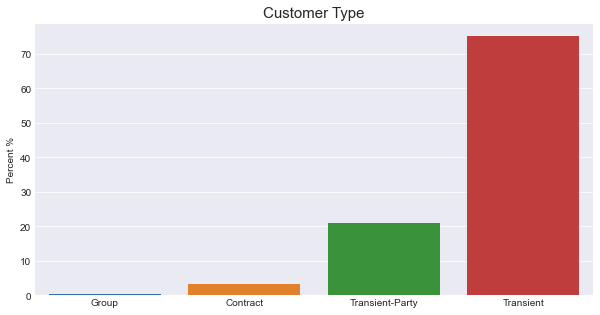

In [159]:
data = df['customer_type'].value_counts(normalize=True, sort=False).mul(100).round(2)

plt.figure(figsize=(10, 5))
plt.title('Customer Type',size=15)
sns.barplot(x=data.index, y=data)
plt.ylabel('Percent %')
plt.xticks(fontsize=10)
plt.show()

In [160]:
col = df['customer_type']
pd.DataFrame(np.array([
    col.value_counts(sort=False),
    col.value_counts(sort=False, normalize=True).mul(100).round(2)]).T,
            index=col.value_counts(sort=False).index,
            columns=['Sum','Percent'])

,Sum,Percent
Group,577.0,0.48
Contract,4076.0,3.41
Transient-Party,25124.0,21.04
Transient,89612.0,75.06


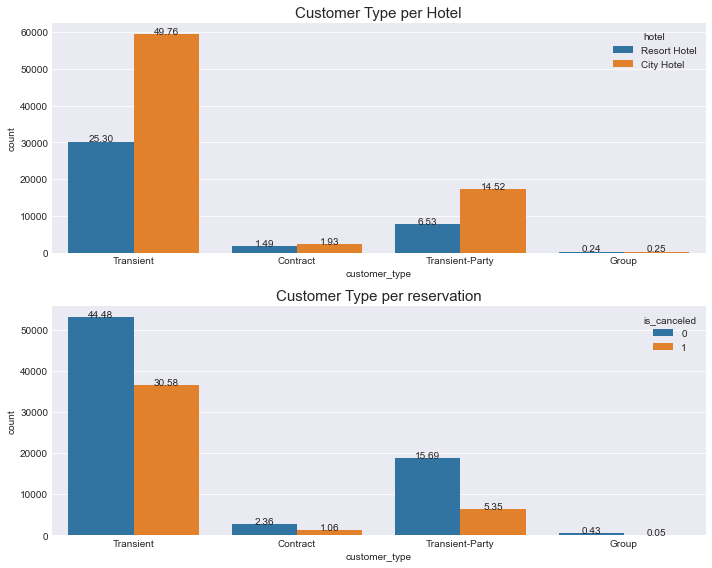

In [161]:
total = float(len(df))
plt.figure(figsize=(10,8))

plt.subplot(211)
plt.title('Customer Type per Hotel',size=15)
ax = sns.countplot(x='customer_type', data=df, hue='hotel')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format((height/total)*100),
            ha="center")

plt.subplot(212)
plt.title('Customer Type per reservation',size=15)
ax = sns.countplot(x='customer_type', data=df, hue='is_canceled')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format((height/total)*100),
            ha="center")
    
plt.tight_layout()
plt.show()

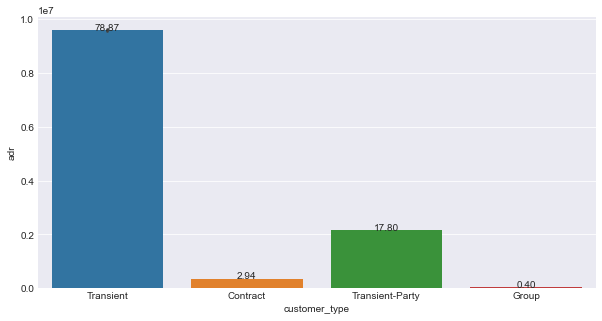

In [162]:
plt.figure(figsize=(10,5))
ax = sns.barplot(x='customer_type', y='adr', data=df, estimator=sum)
total = df['adr'].sum()
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format((height/total)*100),
            ha="center")
    
plt.show()

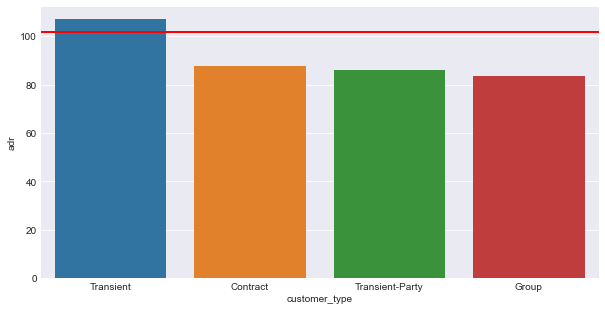

In [163]:
plt.figure(figsize=(10,5))
sns.barplot(x='customer_type', y='adr', data=df, ci=False)
plt.axhline(y=df['adr'].mean(), linewidth=2, color = 'r', label='mean')
plt.show()

- Transient sangat mndominasi untuk segala aspek mulai dari jumlah pemesan, jumlah adr serta rerata adr
- Sehingga dari customer type dapat dibedakan antara Transient dan non-Transient

#### - Agent and Company

In [164]:
data = df.copy()

In [165]:
data['agent'].fillna(0, inplace=True)
data['company'].fillna(0, inplace=True)

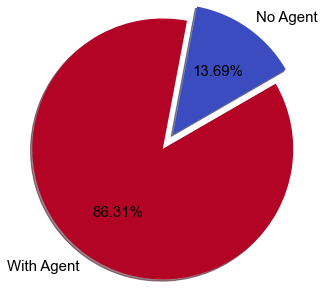

In [166]:
persentase = [data[data['agent'] == 0]['agent'].count(),
              data[data['agent'] != 0]['agent'].count()]
nama = ['No Agent', 'With Agent']
cmap = plt.get_cmap('coolwarm')
warna = [cmap(i) for i in np.linspace(0, 1, 2)]

plt.pie(
    persentase,
    labels=nama,
    colors=warna,
    startangle=30,
    shadow=True,
    radius=1.5,
    textprops={
        'size' : 15,
        'color' : 'k'
    },
    autopct='%.2f%%',
    explode=(.1, .1)
    )
plt.show()

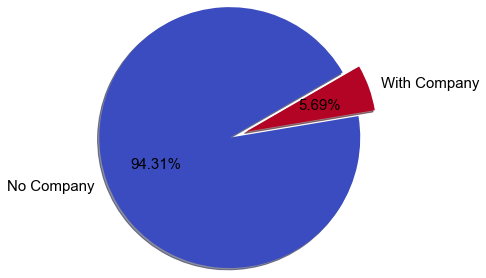

In [167]:
persentase = [data[data['company'] == 0]['company'].count(),
              data[data['company'] != 0]['company'].count()]
nama = ['No Company', 'With Company']
cmap = plt.get_cmap('coolwarm')
warna = [cmap(i) for i in np.linspace(0, 1, 2)]

plt.pie(
    persentase,
    labels=nama,
    colors=warna,
    startangle=30,
    shadow=True,
    radius=1.5,
    textprops={
        'size' : 15,
        'color' : 'k'
    },
    autopct='%.2f%%',
    explode=(.1, .1)
    )
plt.show()

In [168]:
data['company_with'] = data['company'].apply(lambda x: 0 if x == 0 else 1)
data['agent_with'] = data['agent'].apply(lambda x: 0 if x == 0 else 1)

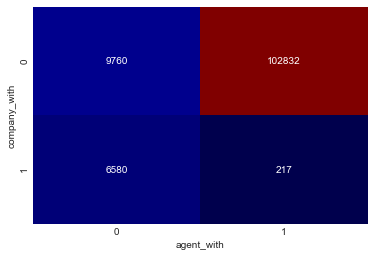

In [169]:
sns.heatmap(pd.crosstab(data['company_with'], data['agent_with']),
            cmap="seismic", annot=True, cbar=False, fmt='g')
plt.show()

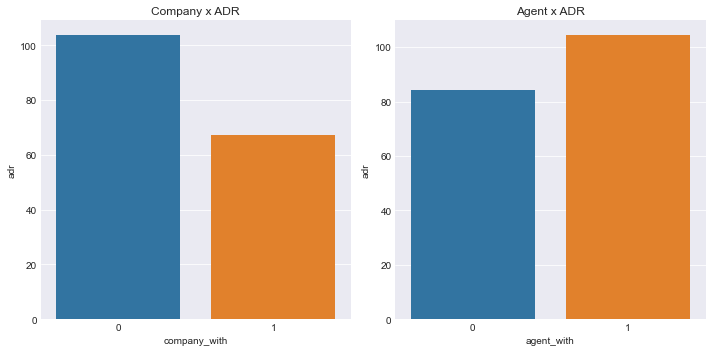

In [170]:
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.title('Company x ADR',size=12)
sns.barplot(x='company_with', y='adr', data=data, ci=False)

plt.subplot(122)
plt.title('Agent x ADR',size=12)
sns.barplot(x='agent_with', y='adr', data=data, ci=False)

plt.tight_layout()
plt.show()

In [171]:
data.groupby(['company_with'])['adr'].mean()

company_with
0    103.870212
1     67.274186
Name: adr, dtype: float64

In [172]:
data.groupby(['agent_with'])['adr'].mean()

agent_with
0     84.250272
1    104.567421
Name: adr, dtype: float64

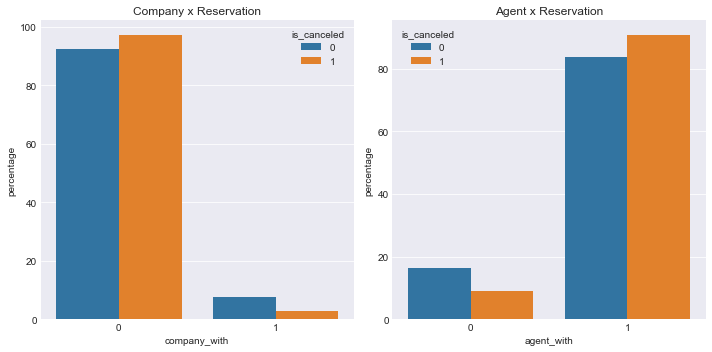

In [173]:
d1 = (data.groupby(['is_canceled'])['company_with']
    .value_counts(normalize=True)
    .rename('percentage')
    .mul(100)
    .reset_index()
    .sort_values('company_with'))

d2 = (data.groupby(['is_canceled'])['agent_with']
    .value_counts(normalize=True)
    .rename('percentage')
    .mul(100)
    .reset_index()
    .sort_values('agent_with'))

plt.figure(figsize=[10,5])
plt.subplot(121)
plt.title('Company x Reservation',size=12)
sns.barplot(x="company_with", y="percentage", hue="is_canceled", data=d1)

plt.subplot(122)
plt.title('Agent x Reservation',size=12)
sns.barplot(x="agent_with", y="percentage", hue="is_canceled", data=d2)

plt.tight_layout()
plt.show()

In [174]:
pd.crosstab(data['is_canceled'], data['company_with'], normalize='columns').mul(100).round(2)

company_with,0,1
is_canceled,,
0,61.78,82.48
1,38.22,17.52


In [175]:
pd.crosstab(data['is_canceled'], data['agent_with'], normalize='columns').mul(100).round(2)

agent_with,0,1
is_canceled,,
0,75.34,61.0
1,24.66,39.0


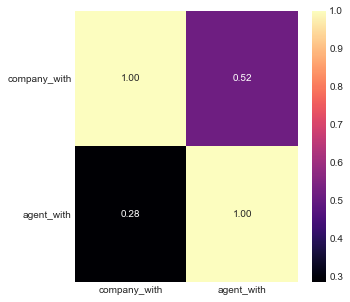

In [176]:
data1 = data[['company_with','agent_with']]

theilu = pd.DataFrame(index=data1.columns,columns=data1.columns)
columns = data1.columns
for i in columns:
    for j in range(0,len(columns)):
        u = theil_u(data1[i].tolist(),data1[columns[j]].tolist())
        theilu.loc[i,columns[j]] = u
theilu.fillna(value=np.nan,inplace=True)
plt.figure(figsize=(5,5))
sns.heatmap(theilu,annot=True,fmt='.2f',cmap='magma')
plt.yticks(rotation=0)
plt.show()

- Pemesan menggunakan agent sekitar 86% dan company sekitar 6%
- Terdapat 217 yang menggunakan agent dan menggunakan company
- Pemesan menggunakan company dan agent banyak yang tidak melakukan pembatalan
- Antara Agent dan Company tidak berhubungan ata berkolerasi

### *5. Bookings Detail*

#### - Stays

In [177]:
df['stays'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']

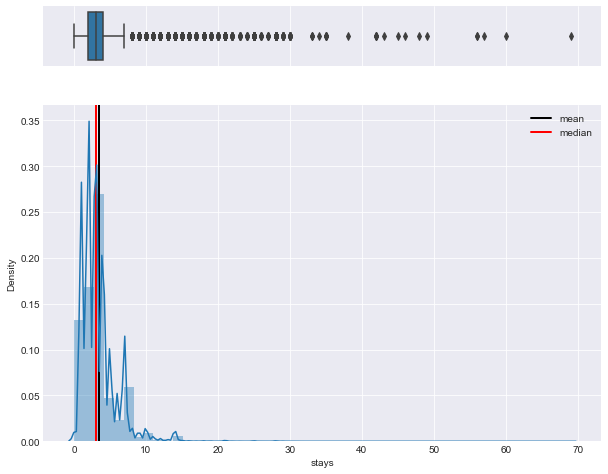

In [178]:
col = df['stays']

# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(figsize=(10,8), nrows=2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
ax_hist.axvline(x=col.mean(), linewidth=2, color = 'k', label='mean') 
ax_hist.axvline(x=col.median(), linewidth=2, color = 'r', label='median')
sns.boxplot(col, ax=ax_box)
sns.distplot(col, ax=ax_hist)

ax_hist.legend()
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
plt.show()

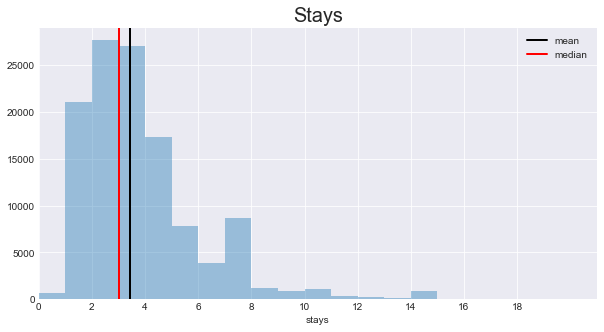

In [179]:
col = df['stays']
col_name = 'Stays'

plt.figure(figsize=(10,5))
sns.distplot(col, bins=np.arange(0,20,1), kde=False)
plt.title(col_name, fontsize=20)
vl1 = plt.axvline(x=col.mean(), linewidth=2, color = 'k', label='mean') 
vl2 = plt.axvline(x=col.median(), linewidth=2, color = 'r', label='median')
plt.xlim(0,21)
plt.xticks(np.arange(0,20,2))
plt.legend(handles = [vl1,vl2])
plt.show()

In [180]:
print(f'Stays Mean   : {df["stays"].mean().round(2)}')
print(f'Stays Median : {df["stays"].median()}')

Stays Mean   : 3.43
Stays Median : 3.0


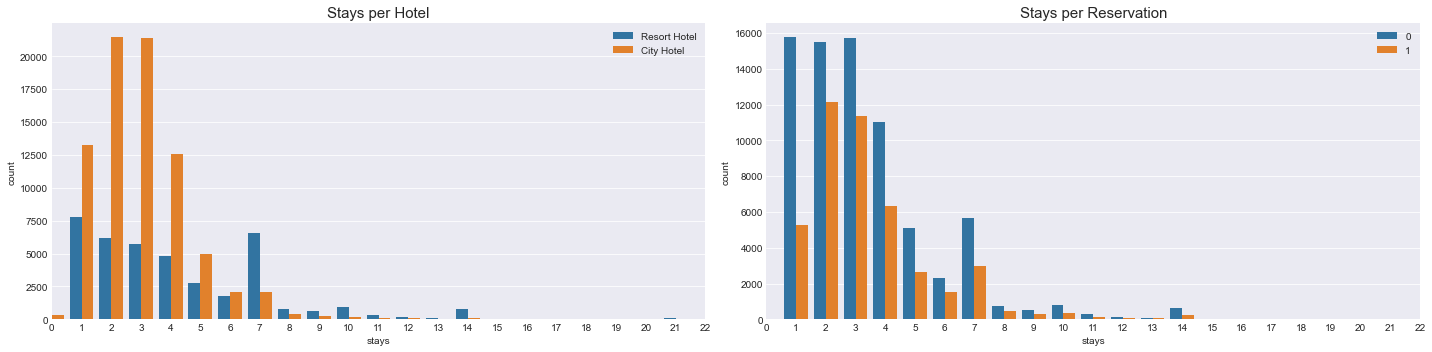

In [181]:
plt.figure(figsize=(20, 5))

plt.subplot(121)
plt.title('Stays per Hotel',size=15)
sns.countplot(x='stays', data=df, hue='hotel')
plt.xlim(0,22)
plt.xticks(fontsize=10)
plt.legend(loc=1)

plt.subplot(122)
plt.title('Stays per Reservation',size=15)
sns.countplot(x='stays', data=df, hue='is_canceled')
plt.xlim(0,22)
plt.xticks(fontsize=10)
plt.legend(loc=1)

plt.tight_layout()
plt.show()

In [182]:
pd.crosstab(index=df['stays'], columns=df['is_canceled']).T

stays,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,33,34,35,38,42,43,45,46,48,49,56,57,60,69
is_canceled,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,680,15749,15480,15725,11025,5121,2322,5686,720,528,783,276,125,91,659,39,18,15,6,6,1,36,10,2,1,14,0,1,23,3,2,0,1,5,1,3,1,1,1,1,1,1,1,1,1
1,35,5270,12163,11351,6358,2663,1535,2969,441,313,356,120,98,51,257,36,22,5,29,16,13,35,4,6,5,23,6,4,12,11,11,3,0,0,0,1,0,0,0,0,0,1,0,0,0


In [183]:
pd.crosstab(index=df['stays'], columns=df['hotel']).T

stays,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,33,34,35,38,42,43,45,46,48,49,56,57,60,69
hotel,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
City Hotel,331,13271,21426,21381,12557,4997,2059,2059,385,213,199,82,65,42,100,42,16,8,7,12,13,10,7,2,6,2,3,4,4,11,8,2,1,0,0,0,1,0,0,1,1,0,1,0,0
Resort Hotel,384,7748,6217,5695,4826,2787,1798,6596,776,628,940,314,158,100,816,33,24,12,28,10,1,61,7,6,0,35,3,1,31,3,5,1,0,5,1,4,0,1,1,0,0,2,0,1,1


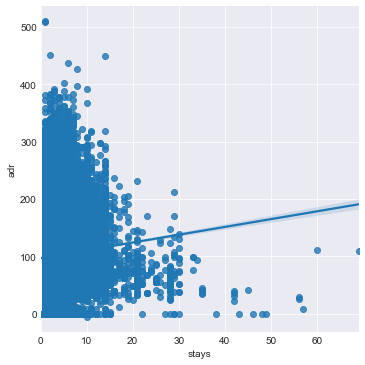

In [184]:
sns.lmplot(x='stays', y='adr', data=df)
plt.show()

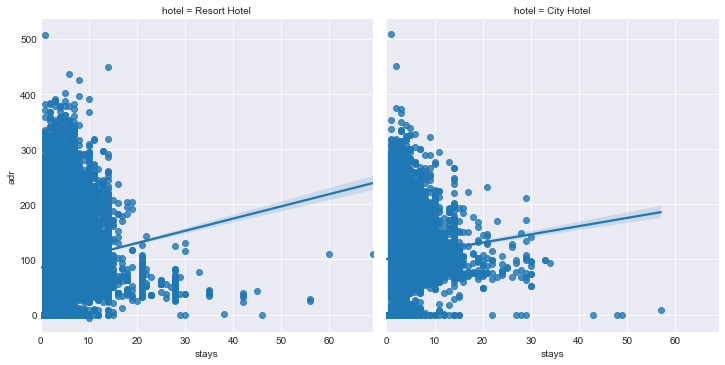

In [185]:
sns.lmplot(x='stays', y='adr', data=df, col='hotel')
plt.show()

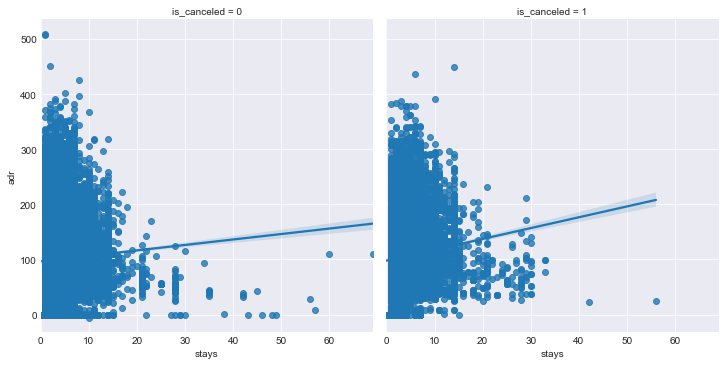

In [186]:
sns.lmplot(x='stays', y='adr', data=df, col='is_canceled')
plt.show()

- Pemesanan menginap paling banyak sekitar 1 smapai 4 hari
- Terlihat secara jeals bahwa semakin lama menginap harganya semakin mahal

#### - Lead Time

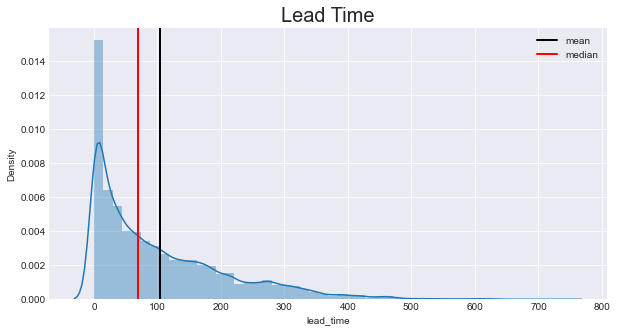

In [187]:
col = df['lead_time']
col_name = 'Lead Time'

plt.figure(figsize=(10,5))
sns.distplot(col)
plt.title(col_name, fontsize=20)
vl1 = plt.axvline(x=col.mean(), linewidth=2, color = 'k', label='mean') 
vl2 = plt.axvline(x=col.median(), linewidth=2, color = 'r', label='median')
# plt.xlim(0,1000)
plt.legend(handles = [vl1,vl2])
plt.show()

In [188]:
print(f'Stays Mean   : {col.mean().round(2)}')
print(f'Stays Median : {col.median()}')

Stays Mean   : 104.01
Stays Median : 69.0


In [189]:
print(f'Kolom lead_time memiliki Skew {col.skew()} dan Kurtosis {col.kurt()}')

Kolom lead_time memiliki Skew 1.3465373174939466 dan Kurtosis 1.696411731310255


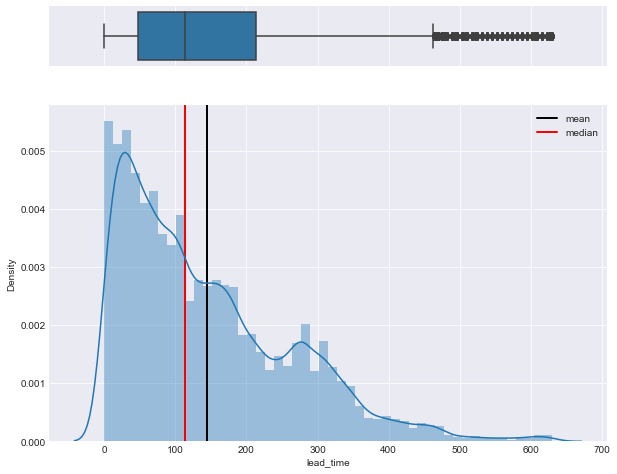

In [190]:
col = df[df['is_canceled'] == 1]['lead_time']
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(figsize=(10,8), nrows=2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
ax_hist.axvline(x=col.mean(), linewidth=2, color = 'k', label='mean') 
ax_hist.axvline(x=col.median(), linewidth=2, color = 'r', label='median')
sns.boxplot(col, ax=ax_box)
sns.distplot(col, ax=ax_hist)

ax_hist.legend()
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
plt.show()

In [191]:
print(f'Stays Mean   : {col.mean().round(2)}')
print(f'Stays Median : {col.median()}')

Stays Mean   : 144.85
Stays Median : 113.0


In [192]:
print(f'Kolom lead_time memiliki Skew {col.skew()} dan Kurtosis {col.kurt()}')

Kolom lead_time memiliki Skew 1.031756896578277 dan Kurtosis 0.7770099190680417


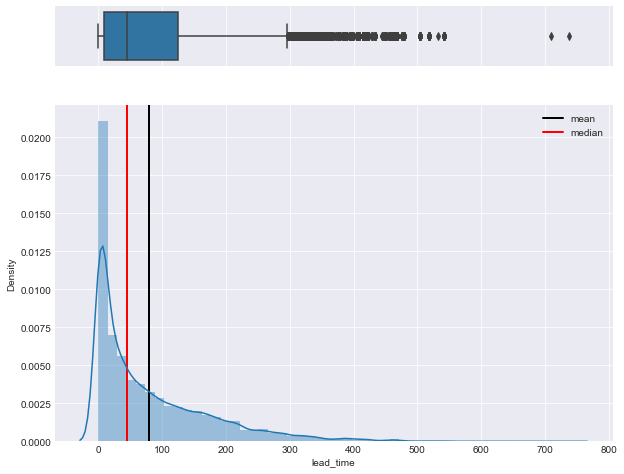

In [193]:
col = df[df['is_canceled'] == 0]['lead_time']
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(figsize=(10,8), nrows=2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
ax_hist.axvline(x=col.mean(), linewidth=2, color = 'k', label='mean') 
ax_hist.axvline(x=col.median(), linewidth=2, color = 'r', label='median')
sns.boxplot(col, ax=ax_box)
sns.distplot(col, ax=ax_hist)

ax_hist.legend()
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
plt.show()

In [194]:
print(f'Stays Mean   : {col.mean().round(2)}')
print(f'Stays Median : {col.median()}')

Stays Mean   : 79.98
Stays Median : 45.0


In [195]:
print(f'Kolom lead_time memiliki Skew {col.skew()} dan Kurtosis {col.kurt()}')

Kolom lead_time memiliki Skew 1.5266874350561124 dan Kurtosis 2.2924288572673293


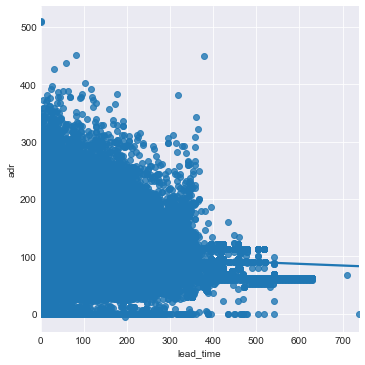

In [196]:
sns.lmplot(x='lead_time', y='adr', data=df[df['adr'] < 5000])
plt.show()

- Lead time banyak yang berkisar di 0
- Pemesanan yang melakukan pembatalan bervariasi datanya dibanding dengan yang tidak melakukan pembatalan terlihat dari nilai skew nya yang membatalkan lebih besar dibanding yang tidak membatlkan
- Banyak yang melakukan pembatalan di lead time sekitar 0
- Lead time dengan ADR tidak terlalu berkorelasi atau berhubungan

### *6. Bookings History*

#### - Repeated Guest

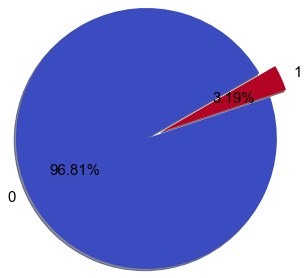

In [197]:
kolom = df['is_repeated_guest']
persen = []
nama = []
for i in kolom.unique():
    nama.append(i)
    persen.append(len(df[kolom == i]))
    
cmap = plt.get_cmap('coolwarm')
warna = [cmap(i) for i in np.linspace(0, 1, len(nama))]

plt.pie(
    persen,
    labels=nama,
    colors=warna,
    startangle=30,
    shadow=True,
    radius=1.5,
    textprops={
        'size' : 15,
        'color' : 'k'
    },
    autopct='%1.2f%%',
    explode=(.1, .1)
    )
plt.show()

In [198]:
df[df['is_repeated_guest'] == 1].mode()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date,arrival_month,stays,kids,family
0,City Hotel,0,0,2016,March,7,20,0,1,1,0.0,0,BB,PRT,Corporate,Corporate,1,0,1,A,A,0,No Deposit,240.0,40.0,0,Transient,0.0,0,0,Check-Out,2014-10-17,2015-10-06,2017-01,1,0.0,0


In [199]:
df[df['is_repeated_guest'] == 1].groupby('hotel').mean()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,stays,kids,family
hotel,,,,,,,,,,,,,,,,,,,,,,,
City Hotel,0.217028,35.900591,2016.050689,27.405512,15.141732,0.355807,1.337106,1.325295,0.025098,0.003937,1.0,0.767224,4.852854,0.241142,34.668061,90.417766,0.168307,64.234793,0.113189,0.633858,1.692913,0.029035,0.021654
Resort Hotel,0.062430,24.941507,2016.363892,22.052306,15.911699,0.552868,1.639483,1.462317,0.039370,0.002250,1.0,0.129921,2.136108,0.291339,196.060440,223.365854,0.164229,64.687373,0.227784,0.622047,2.192351,0.041620,0.029246


In [200]:
df[df['is_repeated_guest'] == 1].groupby('hotel').agg(pd.Series.mode)

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date,arrival_month,stays,kids,family
hotel,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
City Hotel,0,0,2016,October,41,6,0,1,1,0.0,0,BB,PRT,Corporate,Corporate,1,0,0,A,A,0,No Deposit,1.0,40.0,0,Transient,0.0,0,0,Check-Out,2014-10-17,2015-10-06,2015-10,1,0.0,0
Resort Hotel,0,0,2016,February,7,7,0,1,1,0.0,0,BB,PRT,Direct,TA/TO,1,0,1,A,A,0,No Deposit,240.0,154.0,0,Transient,0.0,0,0,Check-Out,2015-11-17,2016-02-07,2017-01,1,0.0,0


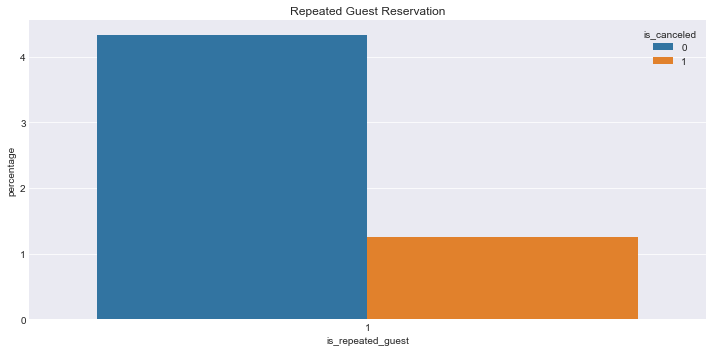

In [201]:
d1 = (df.groupby(['is_canceled'])['is_repeated_guest']
    .value_counts(normalize=True)
    .rename('percentage')
    .mul(100)
    .reset_index()
    .sort_values('is_repeated_guest'))

plt.figure(figsize=[10,5])
plt.title('Repeated Guest Reservation',size=12)
sns.barplot(x="is_repeated_guest", y="percentage", hue="is_canceled", data=d1[d1['is_repeated_guest']==1])

plt.tight_layout()
plt.show()

- 3.19% pemesan merupakan pemesan lama atau memesan kembali
- Pemesan lama cenderung tidak melakukan pembatalan

#### - Previous Cancellations

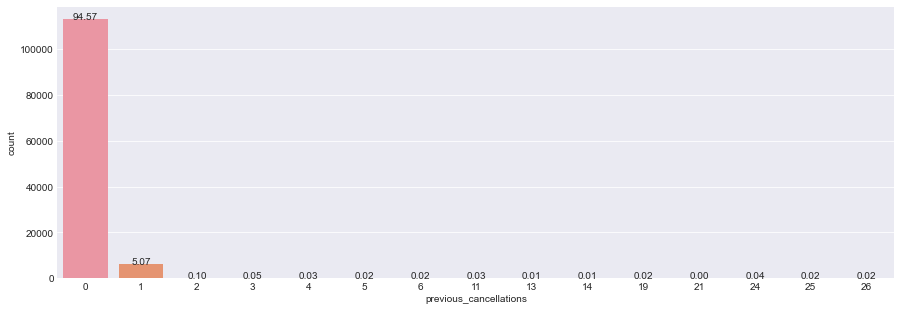

In [202]:
total = float(len(df))
plt.figure(figsize=(15, 5))

ax = sns.countplot(x='previous_cancellations', data=df)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format((height/total)*100),
            ha="center")
plt.show()

In [203]:
df[df['previous_cancellations'] != 0].mode()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date,arrival_month,stays,kids,family
0,City Hotel,1,68,2015,September,38,17,0,2,2,0.0,0,BB,PRT,Groups,TA/TO,0,1,0,A,A,0,Non Refund,1.0,40.0,0,Transient,62.0,0,0,Canceled,2015-01-01,2015-09-17,2015-09,2,0.0,0


In [204]:
df[df['previous_cancellations'] != 0].groupby('hotel').mean()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,stays,kids,family
hotel,,,,,,,,,,,,,,,,,,,,,,,
City Hotel,0.931156,201.580813,2015.348673,31.809798,15.594359,0.627018,1.856745,1.779922,0.007423,0.001299,0.137688,1.173873,1.138616,0.039525,14.565999,76.056034,4.930785,78.105240,0.012804,0.164223,2.483763,0.008721,0.005938
Resort Hotel,0.843836,170.184475,2015.409132,32.295890,14.223744,1.084932,2.953425,1.777169,0.040183,0.001826,0.168950,3.721461,1.240183,0.113242,173.533058,194.286996,0.007306,68.048685,0.042009,0.393607,4.038356,0.042009,0.028311


In [205]:
df[df['previous_cancellations'] != 0].groupby('hotel').agg(pd.Series.mode)

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date,arrival_month,stays,kids,family
hotel,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
City Hotel,1,68,2015,September,38,0,2,2,0.0,0,BB,PRT,Groups,TA/TO,0,1,0,A,A,0,Non Refund,1.0,40.0,0,Transient,62,0,0,Canceled,2015-01-01,2015-12-08,2015-09,2,0.0,0
Resort Hotel,1,259,2015,September,38,0,1,2,0.0,0,BB,PRT,Groups,TA/TO,0,1,0,A,A,0,No Deposit,240.0,223.0,0,Transient,"[34.0, 79.0]",0,0,Canceled,2015-01-21,2015-09-17,2015-09,3,0.0,0


#### - Previous Bookings not Canceled

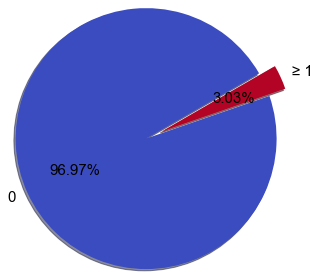

In [206]:
persentase = [df[df['previous_bookings_not_canceled'] == 0]['previous_bookings_not_canceled'].count(),
              df[df['previous_bookings_not_canceled'] != 0]['previous_bookings_not_canceled'].count()]
nama = ['0', '≥ 1']
cmap = plt.get_cmap('coolwarm')
warna = [cmap(i) for i in np.linspace(0, 1, 2)]

plt.pie(
    persentase,
    labels=nama,
    colors=warna,
    startangle=30,
    shadow=True,
    radius=1.5,
    textprops={
        'size' : 15,
        'color' : 'k'
    },
    autopct='%1.2f%%',
    explode=(.1, .1)
    )
plt.show()

In [207]:
df[df['previous_bookings_not_canceled'] != 0].mode()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date,arrival_month,stays,kids,family
0,Resort Hotel,0,0,2016,March,4,21,0,1,1,0.0,0,BB,PRT,Corporate,Corporate,1,0,1,A,A,0,No Deposit,240.0,40.0,0,Transient,65.0,0,0,Check-Out,2016-09-22,2016-09-21,2017-01,1,0.0,0


In [208]:
df[df['previous_bookings_not_canceled'] != 0].groupby('hotel').mean()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,stays,kids,family
hotel,,,,,,,,,,,,,,,,,,,,,,,
City Hotel,0.076196,22.574307,2016.285894,25.358942,15.356423,0.434509,1.261965,1.239295,0.025189,0.004408,0.891058,0.789673,6.612720,0.297229,39.894737,89.386503,0.911209,70.408873,0.144836,0.785894,1.696474,0.029597,0.022670
Resort Hotel,0.038878,26.204232,2016.325787,22.794783,16.018701,0.569882,1.832677,1.353346,0.031988,0.000492,0.700295,0.137303,2.887303,0.309547,205.693848,204.082500,0.205217,65.464783,0.257382,0.658465,2.402559,0.032480,0.022638


In [209]:
df[df['previous_bookings_not_canceled'] != 0].groupby('hotel').agg(pd.Series.mode)

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date,arrival_month,stays,kids,family
hotel,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
City Hotel,0,0,2016,June,24,21,0,1,1,0.0,0,BB,PRT,Corporate,Corporate,1,0,1,A,A,0,No Deposit,9.0,40.0,0,Transient,65.0,0,0,Check-Out,2016-09-22,2016-09-21,2017-05,1,0.0,0
Resort Hotel,0,0,2016,March,4,20,0,1,1,0.0,0,BB,PRT,Corporate,Corporate,1,0,1,A,D,0,No Deposit,240.0,154.0,0,Transient,35.0,0,0,Check-Out,2017-05-25,2017-03-29,2017-03,1,0.0,0


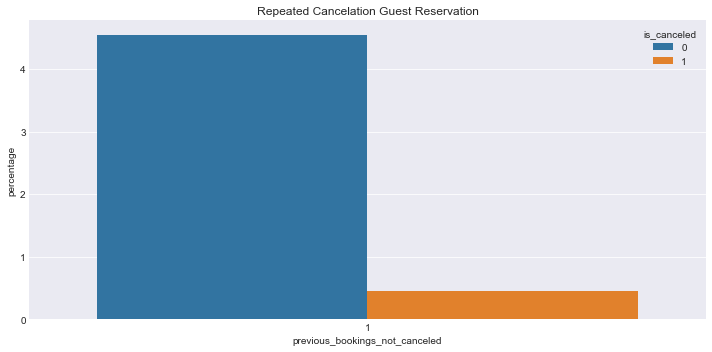

In [210]:
data = df[['is_canceled','previous_bookings_not_canceled']]
data['previous_bookings_not_canceled'] = data['previous_bookings_not_canceled'].apply(lambda x: 0 if x==0 else 1)

d1 = (data.groupby(['is_canceled'])['previous_bookings_not_canceled']
    .value_counts(normalize=True)
    .rename('percentage')
    .mul(100)
    .reset_index()
    .sort_values('previous_bookings_not_canceled'))

plt.figure(figsize=[10,5])
plt.title('Repeated Cancelation Guest Reservation',size=12)
sns.barplot(x="previous_bookings_not_canceled", y="percentage", hue="is_canceled", data=d1[d1['previous_bookings_not_canceled']!=0])

plt.tight_layout()
plt.show()

- 3.03% Pemesan pernah melakukan pembatalan sebelumnya
- Terlihat jelas bahwa yang telah melakukan pembatalan sebelumnya justru saat melakukan pemesanan tidak melakukan pembatalan lagi

#### - New Costumer

In [211]:
data = df[(df['is_repeated_guest'] == 0) & (df['previous_cancellations'] == 0) & (df['previous_bookings_not_canceled'] == 0)]

In [212]:
print(f'Jumlah Pelanggan Baru sebesar {len(data)} atau {round((len(data)/len(df))*100,2)}%')

Jumlah Pelanggan Baru sebesar 109342 atau 91.58%


In [213]:
data.groupby('hotel').mean()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,stays,kids,family
hotel,,,,,,,,,,,,,,,,,,,,,,,
City Hotel,0.386448,104.734657,2016.235671,26.835276,15.808680,0.816101,2.228111,1.867211,0.098680,0.005201,0.0,0.0,0.0,0.195831,29.054285,174.579339,3.154088,108.044841,0.023424,0.572333,3.044212,0.103881,0.073499
Resort Hotel,0.275841,94.293398,2016.130607,27.250631,15.866245,1.229085,3.214160,1.894603,0.136306,0.014952,0.0,0.0,0.0,0.292475,218.864957,255.980866,0.562400,97.482323,0.134352,0.626930,4.443244,0.151258,0.103986


In [214]:
data.groupby('hotel').agg(pd.Series.mode)

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date,arrival_month,stays,kids,family
hotel,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
City Hotel,0,0,2016,August,33,15,0,2,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9.0,40.0,0,Transient,62.0,0,0,Check-Out,2015-10-21,2016-11-07,2017-05,3,0.0,0
Resort Hotel,0,0,2016,August,33,12,2,1,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,223.0,0,Transient,48.0,0,0,Check-Out,2017-01-19,2015-12-05,2016-10,1,0.0,0


In [215]:
data.groupby('is_canceled').mean()

,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,stays,kids,family
is_canceled,,,,,,,,,,,,,,,,,,,,,,
0,83.282900,2016.139665,27.245858,15.852030,0.954499,2.518893,1.856723,0.106123,0.010778,0.0,0.0,0.0,0.292441,93.028446,216.640075,1.66269,102.005967,0.093433,0.715245,3.473392,0.116901,0.083751
1,134.641164,2016.313209,26.470887,15.783441,0.956756,2.637864,1.913198,0.121126,0.004217,0.0,0.0,0.0,0.109039,81.568545,198.838524,3.43241,109.105766,0.000000,0.358653,3.594620,0.125344,0.083816


In [216]:
data.groupby('is_canceled').agg(pd.Series.mode)

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date,arrival_month,stays,kids,family
is_canceled,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,City Hotel,0,2016,August,33,25,0,1,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9.0,223.0,0,Transient,75.0,0,0,Check-Out,2015-12-08,2015-12-05,2016-10,3,0.0,0
1,City Hotel,0,2016,May,33,15,0,2,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9.0,67.0,0,Transient,62.0,0,0,Canceled,2015-10-21,2016-11-07,2017-05,3,0.0,0


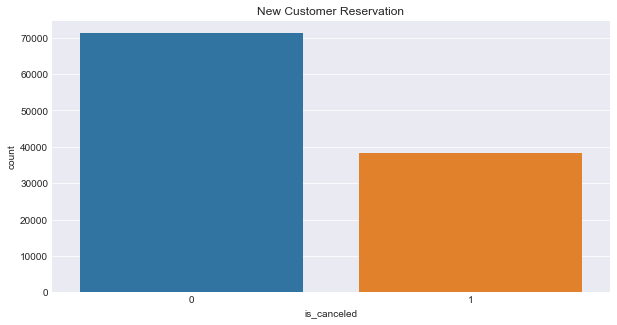

In [217]:
plt.figure(figsize=[10,5])
plt.title('New Customer Reservation',size=12)
sns.countplot(x="is_canceled", data=data)

plt.show()

In [218]:
d1 = data['is_canceled'].value_counts().to_frame()
d1['percent'] = (d1['is_canceled']/d1['is_canceled'].sum()).mul(100).round(2)
d1

,is_canceled,percent
0,71163,65.08
1,38179,34.92


- Terlihat bahwa perbandingan dengan yang membatalkan dengan tidak sama seperti perbandingan keseluruhan antara yang membatalkan dengan yang tidak
- Pelanggan baru mendominasi data pemesanan sebesar 91.58%

### *7. Amneties*

#### - Room Type

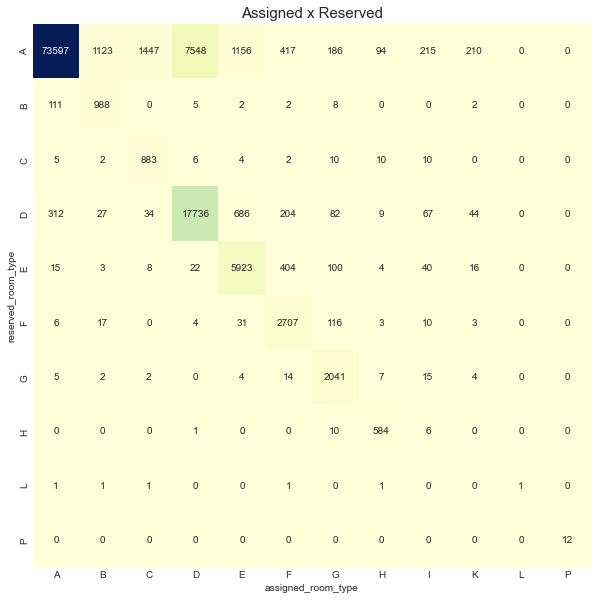

In [219]:
plt.figure(figsize=[10,10])
plt.title('Assigned x Reserved', size=15)
sns.heatmap((pd.crosstab(df['reserved_room_type'], df['assigned_room_type'])),
            cmap="YlGnBu", annot=True, cbar=False, fmt='d')
plt.show()

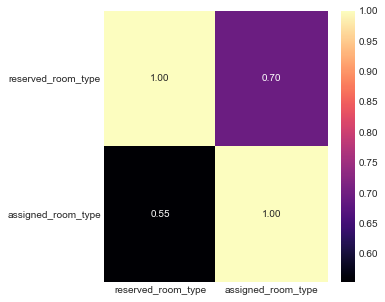

In [220]:
data = df[['reserved_room_type','assigned_room_type']]

theilu = pd.DataFrame(index=data.columns,columns=data.columns)
columns = data.columns
for i in columns:
    for j in range(0,len(columns)):
        u = theil_u(data[i].tolist(),data[columns[j]].tolist())
        theilu.loc[i,columns[j]] = u
theilu.fillna(value=np.nan,inplace=True)
plt.figure(figsize=(5,5))
sns.heatmap(theilu,annot=True,fmt='.2f',cmap='magma')
plt.yticks(rotation=0)
plt.show()

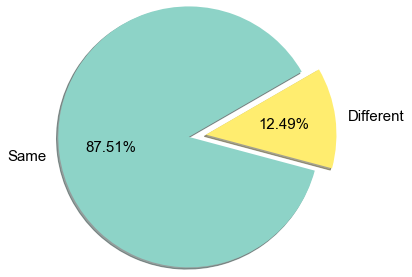

In [236]:
k = 0
for i in df.index:
    if df['assigned_room_type'].loc[i] != df['reserved_room_type'].loc[i]:
        k += 1

persentase = [len(df)-k, k]
nama = ['Same', 'Different']
cmap = plt.get_cmap('Set3')
warna = [cmap(i) for i in np.linspace(0, 1, 2)]

plt.pie(
    persentase,
    labels=nama,
    colors=warna,
    startangle=30,
    shadow=True,
    radius=1.5,
    textprops={
        'size' : 15,
        'color' : 'k'
    },
    autopct='%1.2f%%',
    explode=(.1, .1)
    )
plt.show()

Secara korelasi cukup berkorelasi, yaitu reserved dapat merepresentasikan kolom assigned secara theils u sebesar 70%. Dan memiliki kesamaan secara variabel yang sama sebanyak 87.51%

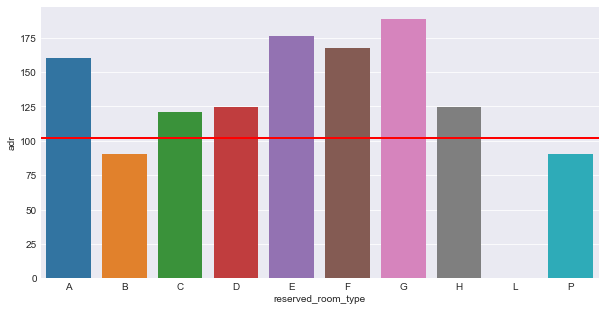

In [237]:
plt.figure(figsize=(10, 5))
sns.barplot(x='reserved_room_type', y='adr', data=df, ci=False)
plt.axhline(y=df['adr'].mean(), linewidth=2, color = 'r', label='mean')
plt.xticks(np.arange(df['reserved_room_type'].nunique()), sorted(df['reserved_room_type'].unique()))
plt.show()

Tipe kamar dapat diketagerikan menjadi tiga kelompok :
- Murah yang rata rata harga perkamar dibawah adr 100 yaitu B, L, P
- Sedang yang rata rata harga perkamar dibawah 150 dan diatas 100 yaitu C, D, H
- Mahal yang nilainya diatas 150 adr yaitu A, E, F, G

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


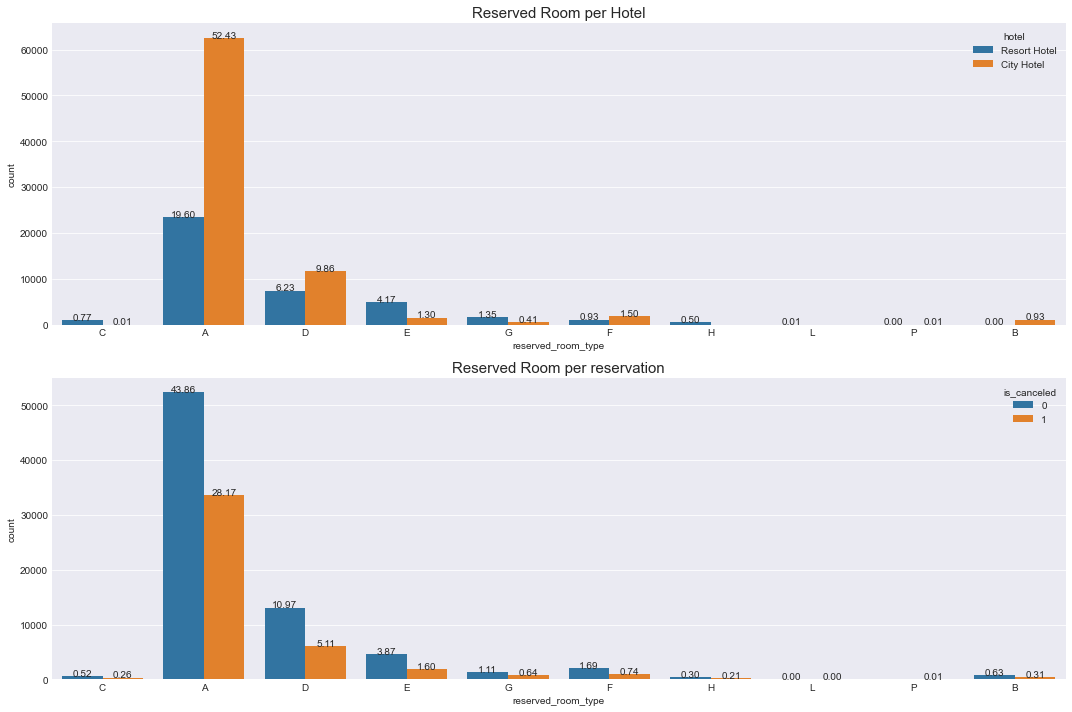

In [238]:
total = float(len(df))
plt.figure(figsize=(15, 10))

plt.subplot(211)
plt.title('Reserved Room per Hotel',size=15)
ax = sns.countplot(x='reserved_room_type', data=df, hue='hotel')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format((height/total)*100),
            ha="center")

plt.subplot(212)
plt.title('Reserved Room per reservation',size=15)
ax = sns.countplot(x='reserved_room_type', data=df, hue='is_canceled')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format((height/total)*100),
            ha="center")
    
plt.tight_layout()
plt.show()

- Pemesanan banyak memesan kamar jenis A
- Secara theils u dan kesamaan variabel, feature reserved room dapat mewakili feature assigned room
- Dapat diketahui kamar terdapat 3 jenis secara harga yaitu murah, sedang dan mahal terlihat dari rerata adr nya

#### - Meal

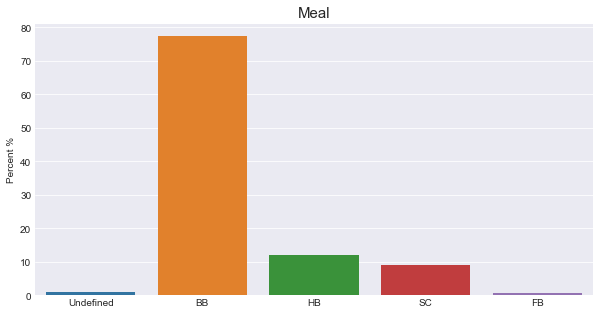

In [239]:
data = df['meal'].value_counts(normalize=True, sort=False).mul(100).round(2)

plt.figure(figsize=(10, 5))
plt.title('Meal',size=15)
sns.barplot(x=data.index, y=data)
plt.ylabel('Percent %')
plt.xticks(fontsize=10)
plt.show()

In [240]:
data = df['meal'].value_counts().to_frame()
data['percentage'] = (data['meal']*100/data['meal'].sum()).round(2)
data.sort_index()

,meal,percentage
BB,92309,77.32
FB,798,0.67
HB,14463,12.11
SC,10650,8.92
Undefined,1169,0.98


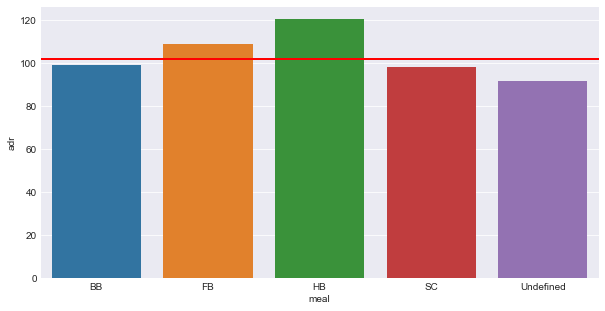

In [241]:
plt.figure(figsize=(10, 5))
sns.barplot(x='meal', y='adr', data=df, ci=False)
plt.axhline(y=df['adr'].mean(), linewidth=2, color = 'r', label='mean')
plt.show()

posx and posy should be finite values
posx and posy should be finite values


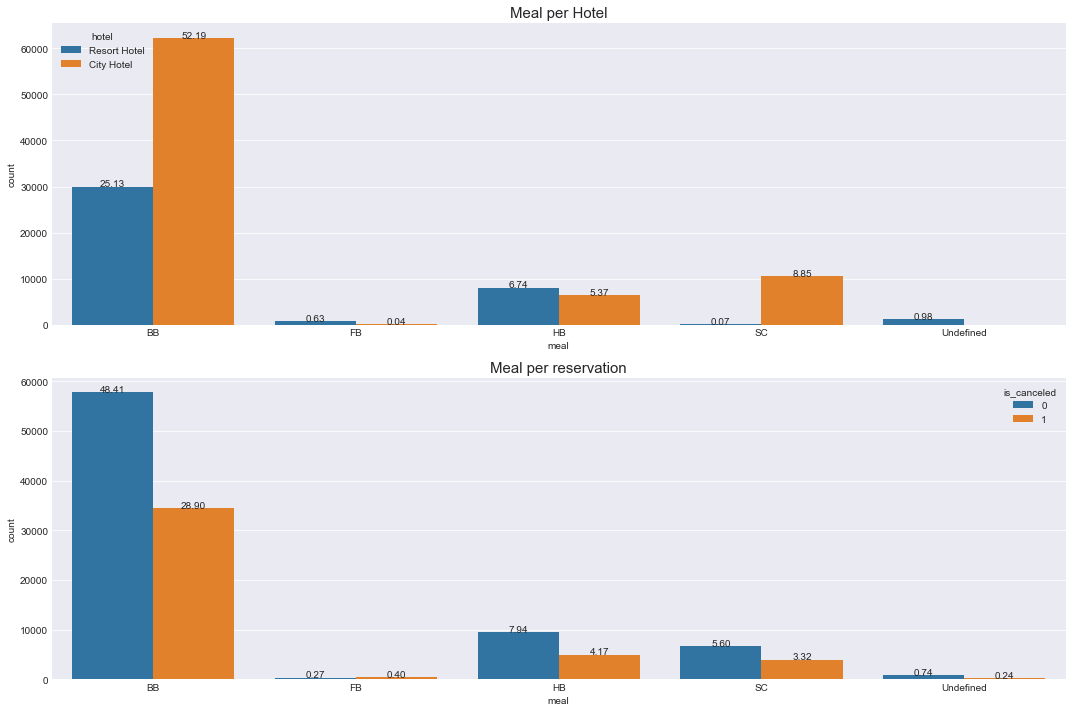

In [242]:
total = float(len(df))
plt.figure(figsize=(15, 10))

plt.subplot(211)
plt.title('Meal per Hotel',size=15)
ax = sns.countplot(x='meal', data=df, hue='hotel')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format((height/total)*100),
            ha="center")

plt.subplot(212)
plt.title('Meal per reservation',size=15)
ax = sns.countplot(x='meal', data=df, hue='is_canceled')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format((height/total)*100),
            ha="center")
    
plt.tight_layout()
plt.show()

- Terlihat kolom merupakan ordinal terbukti dengan semakin banyaknya pemesanan makan semakin mahal
- Banyak yang memesan BB sebanyak 77.32%

#### - Special Request

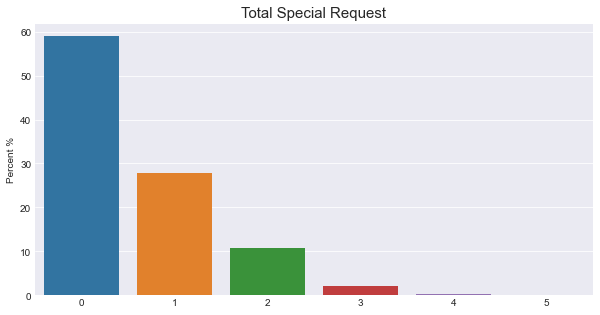

In [243]:
data = df['total_of_special_requests'].value_counts(normalize=True, sort=False).mul(100).round(2)

plt.figure(figsize=(10, 5))
plt.title('Total Special Request',size=15)
sns.barplot(x=data.index, y=data)
plt.ylabel('Percent %')
plt.xticks(fontsize=10)
plt.show()

In [244]:
data = df['total_of_special_requests'].value_counts().to_frame()
data['percentage'] = (data['total_of_special_requests']*100/data['total_of_special_requests'].sum()).round(2)
data.sort_index()

,total_of_special_requests,percentage
0,70317,58.90
1,33226,27.83
2,12969,10.86
3,2497,2.09
4,340,0.28
5,40,0.03


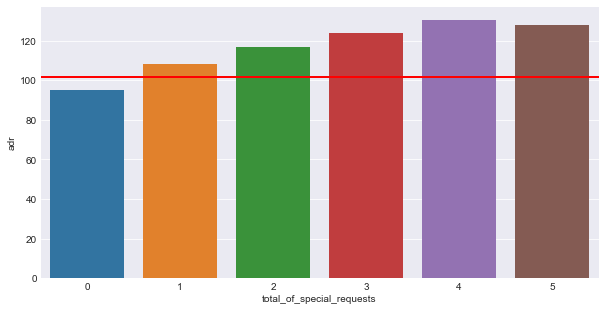

In [245]:
plt.figure(figsize=(10, 5))
sns.barplot(x='total_of_special_requests', y='adr', data=df, ci=False)
plt.axhline(y=df['adr'].mean(), linewidth=2, color = 'r', label='mean')
plt.show()

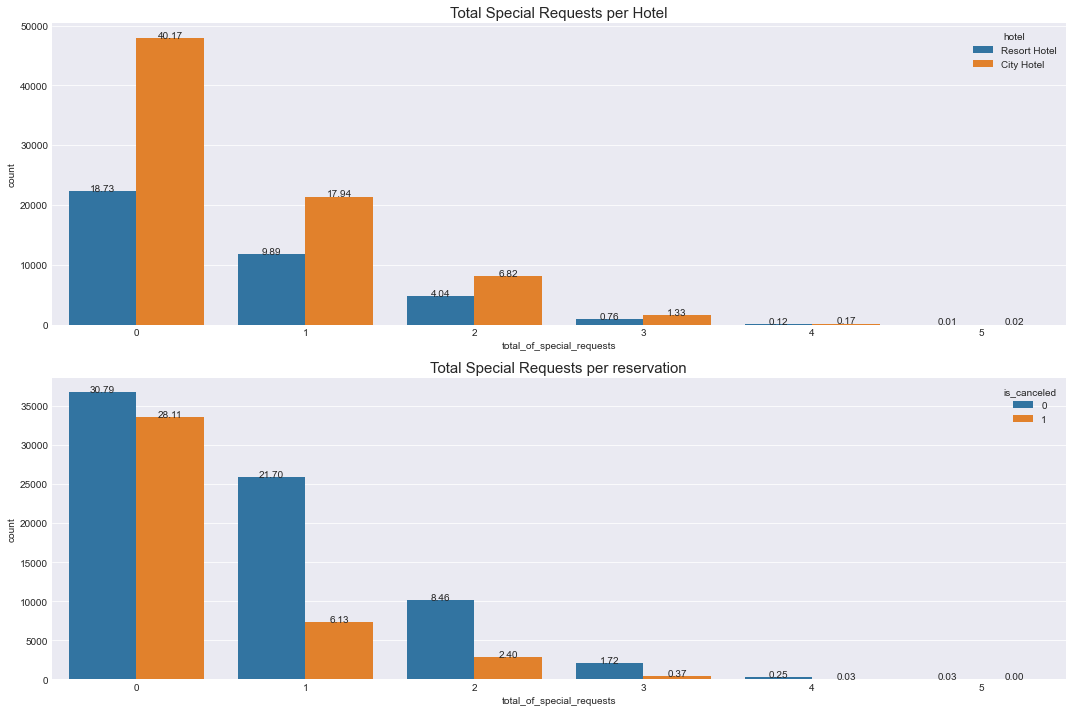

In [246]:
total = float(len(df))
plt.figure(figsize=(15, 10))

plt.subplot(211)
plt.title('Total Special Requests per Hotel',size=15)
ax = sns.countplot(x='total_of_special_requests', data=df, hue='hotel')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format((height/total)*100),
            ha="center")

plt.subplot(212)
plt.title('Total Special Requests per reservation',size=15)
ax = sns.countplot(x='total_of_special_requests', data=df, hue='is_canceled')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format((height/total)*100),
            ha="center")
    
plt.tight_layout()
plt.show()

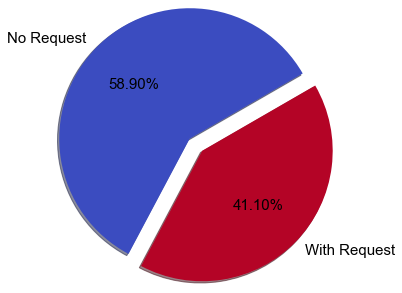

In [247]:
persentase = [df[df['total_of_special_requests'] == 0]['total_of_special_requests'].count(),
              df[df['total_of_special_requests'] != 0]['total_of_special_requests'].count()]
nama = ['No Request', 'With Request']
cmap = plt.get_cmap('coolwarm')
warna = [cmap(i) for i in np.linspace(0, 1, 2)]

plt.pie(
    persentase,
    labels=nama,
    colors=warna,
    startangle=30,
    shadow=True,
    radius=1.5,
    textprops={
        'size' : 15,
        'color' : 'k'
    },
    autopct='%.2f%%',
    explode=(.1, .1)
    )
plt.show()

In [251]:
data = df.copy()
data['total_of_special_requests'] = data['total_of_special_requests'].apply(lambda x: 0 if x==0 else 1)

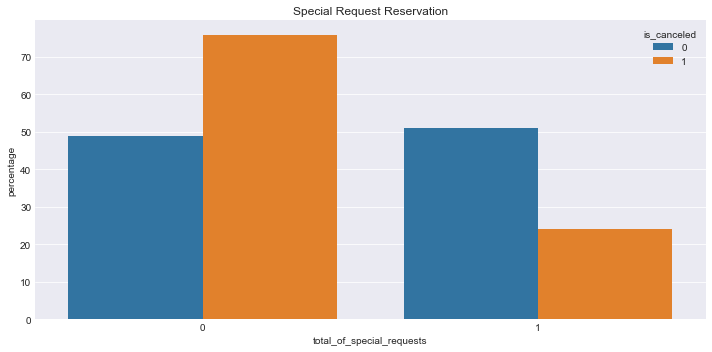

In [252]:
d1 = (data.groupby(['is_canceled'])['total_of_special_requests']
    .value_counts(normalize=True)
    .rename('percentage')
    .mul(100)
    .reset_index()
    .sort_values('total_of_special_requests'))

plt.figure(figsize=[10,5])
plt.title('Special Request Reservation',size=12)
sns.barplot(x="total_of_special_requests", y="percentage", hue="is_canceled", data=d1)

plt.tight_layout()
plt.show()

- Special request paling banyak 0 atau tidak melakukan special request sebanyak 58.90%, sedangkan yang ada special request sebesar 41.10%
- Semakin banyak special request semakin mahal terlihat dari jumlah rerata adrnya semakin banyak semakin meningkat
- Pemesan terdapat special request melakukan pembatalan sedikit, dibandingkan dengan yang melakukan special request banyak yang melakukan pembatalan

## Conclusion

Secara umum dapat disimpulkan bahwa:
- Data memiliki 37.04% pembatalan dan 62.96% tidak membatalkan
- Data terdiri 33.55% Resort Hotel dan 66.45% City Hotel
- Rata-rata ADR sebesar 101.79
- Tiap bulan Januari pemesanan mrngalami penurunan
- Tiap bulan Agustus dan September terjadi lonjakan ADR dari jumlah total maupun reratanya
- Tiap Agustus orang menginap lebih lama dibanding bulan lain
- Pada Agustus 2017 terjadi penurunan secara pemesanan namun kenaikan secara jumlah pemasukan
- 7.82% pemesanan terdapat anak dan atau bayi
- 40.9% merupakan wisatawan lokal sedanglan lainnya merupakan manca negara
- Pemesanan cenderung menggunakan TA/TO serta banyak melalui internet atau online
- Hampir keseluruhan merupakan pemesan baru sekitar 91.58%
- Semakin banyak special request semakin mahal terlihat dari jumlah rerata adrnya semakin banyak semakin meningkat

Secara Jenis Hotel:
- City Hotel lebih mahal dibandingkan dengan Resort Hotel
- Distribusi ADR City Hotel lebih baik dibanding dengan Resort Hotel
- Tiap bulan Agustus di Resort Hotel pemesan memesan lebih lama yaitu sekitar 5 hari
- Wisatawan manca negara banyak yang memesan City Hotel

Faktor yang membatalkan atau tidak pemesanan:
- Dari data pemesanan dengan jumlah adult lebih dari 4 dipastikan membatalkan pemesanan
- Wisatawan lokal banyak yang melakukan pembatalan dibandingkan dengan mancanegara
- 67.15% pemesanan yang dibatalkan tidak menggunakan deposit (no deposit)
- Pemesan menggunakan company dan agent banyak yang tidak melakukan pembatalan
- Pemesan yang melakukan pembatalan sebelumnya justru saat melakukan pemesanan tidak melakukan pembatalan lagi
- Pemesan yang tidak melakukan special request melakukan pembatalan lebih banyak dibandingkan dengan yang memiliki special request

## Saran

Untuk menghindari seseorang melakukan pembatalan antara lain:
- Pemesanan menggunakan deposit, saat melakukan pembatalan pihak hotel tidak terlalu rugi karena terdapat biaya kompensasi dari deposit
- Membatasi jumlah pemesan dewasa tidak lebih dari 4
- Penjualan lebih banyak melalui pihak ketiga seperti travel agent, agent atau company
- Penjualan difokuskan pada wisatawan luar negeri untuk menghindari pembatalan
- Menekankan terdapat bundle atau paket khusus untuk meningkatkan pemesan melakukan special request